In [ ]:
!pip install transformers accelerate torch bitsandbytes gudhi ripser persim scikit-dimension

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
import math
import json
import torch
import torch.nn.functional as F
import numpy as np

from dataclasses import dataclass
from typing import Dict, List, Tuple

from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.linear_model import LinearRegression

import os, torch
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "meta-llama/llama-3.2-1B"
HF_TOKEN = os.getenv("HF_TOKEN", None)

MAX_SEQ = 256
CAPTURE_LAYERS = None
BAND_SLICES = {f"b{i}": 0.1 for i in range(10)}

CSV_PATH = "wiki_dataset_sink.csv" #dataset available on Github
df = pd.read_csv(CSV_PATH)

# Use first column as text (assuming it’s column 0)
TEXTS = df.iloc[:, 0].dropna().astype(str).tolist()
TEXT = " ".join(TEXTS[:5])

from transformers import AutoTokenizer, AutoModelForCausalLM
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, use_auth_token=HF_TOKEN).to(device)

# Encode (batch of texts or one long string)
enc = tok(TEXT, return_tensors="pt", truncation=True, max_length=MAX_SEQ, add_special_tokens=False)
for k in enc:
    enc[k] = enc[k].to(device)

print("✅ Dataset loaded:", len(TEXTS), "rows. Example snippet:", TEXTS[0][:200])



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

✅ Dataset loaded: 811 rows. Example snippet: The generalization of this statement, namely that the laws of special relativity hold to good approximation in freely falling (and non-rotating) reference frames, is known as the Einstein equivalence 


In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    token=HF_TOKEN,
    torch_dtype=torch.float16 if device=="cuda" else torch.float32,
    low_cpu_mem_usage=True,
    device_map="auto",
    attn_implementation="eager",  # important: makes hooks predictable
)
model.eval()


`torch_dtype` is deprecated! Use `dtype` instead!


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [6]:
# ---- RoPE spec helpers (adds Mistral awareness) -----------------------
from typing import Dict, Optional, Tuple
import torch

def get_rope_spec_from_config(cfg) -> dict:
    """
    Extract a best-effort RoPE spec across Llama/Qwen/Gemma/Mistral.
    """
    spec = {
        "base": None,
        "scaling_type": None,
        "scaling_factor": None,
        "rotary_dim_fraction": None,
        "rotary_dim": None,
    }

    # Common base/theta fields across families
    for k in ("rope_theta", "rope_base", "rope_theta_base", "rope_theta_scale", "rope_theta_value"):
        if hasattr(cfg, k):
            try:
                spec["base"] = float(getattr(cfg, k))
                break
            except Exception:
                pass

    # Some families store details inside rope_scaling dict
    rope_scaling = getattr(cfg, "rope_scaling", None)
    if isinstance(rope_scaling, dict):
        spec["scaling_type"] = rope_scaling.get("type", None)
        for k in ("factor", "short_factor", "long_factor", "high_freq_factor", "low_freq_factor"):
            if k in rope_scaling and rope_scaling[k] is not None:
                try:
                    spec["scaling_factor"] = float(rope_scaling[k]); break
                except Exception:
                    pass
        for k in ("base", "rope_theta"):
            if k in rope_scaling and rope_scaling[k] is not None:
                try:
                    spec["base"] = float(rope_scaling[k])
                except Exception:
                    pass

    # Partial rotation fraction
    for k in ("partial_rotary_factor", "rotary_pct", "rope_pct", "rotary_dim_fraction"):
        if hasattr(cfg, k):
            try:
                spec["rotary_dim_fraction"] = float(getattr(cfg, k)); break
            except Exception:
                pass

    # Explicit rotary_dim
    for k in ("rotary_dim", "rope_dim", "rotary_ndims"):
        if hasattr(cfg, k):
            try:
                spec["rotary_dim"] = int(getattr(cfg, k)); break
            except Exception:
                pass

    return spec

def infer_rotary_dim(head_dim: int, cfg) -> Tuple[int, dict]:
    spec = get_rope_spec_from_config(cfg)
    if spec["rotary_dim"] is not None and 0 < spec["rotary_dim"] <= head_dim:
        rd = int(spec["rotary_dim"])
    elif spec["rotary_dim_fraction"] is not None and 0 < spec["rotary_dim_fraction"] <= 1.0:
        rd = int(round(head_dim * float(spec["rotary_dim_fraction"])))
    else:
        rd = head_dim  # default: full rotation

    # RoPE pairs → enforce even and in-range
    if rd % 2 == 1: rd -= 1
    rd = max(2, min(rd, head_dim))
    spec["rotary_dim_effective"] = rd
    return rd, spec

def rope_inv_freq_pairs(num_pairs: int, base: float = 10000.0) -> torch.Tensor:
    i = torch.arange(0, num_pairs, dtype=torch.float32)
    return 1.0 / (base ** (i / num_pairs))

def rope_band_masks(
    head_dim: int,
    bands: Dict[str, float],
    *,
    model=None,
    rotary_dim_override: Optional[int] = None,
    base_override: Optional[float] = None,
) -> Dict[str, torch.Tensor]:
    """
    Returns boolean masks over the *rotated pair space* only: dict[name] -> [num_pairs_rot] bool.
    """
    if rotary_dim_override is not None:
        rotary_dim = int(rotary_dim_override)
        if rotary_dim % 2 == 1: rotary_dim -= 1
        rotary_dim = max(2, min(rotary_dim, head_dim))
        spec = {"rotary_dim_effective": rotary_dim, "base": base_override}
    else:
        cfg = getattr(model, "config", object()) if model is not None else object()
        rotary_dim, spec = infer_rotary_dim(head_dim, cfg)
        if base_override is not None:
            spec["base"] = base_override

    num_pairs_rot = rotary_dim // 2
    if num_pairs_rot <= 0:
        return {name: torch.zeros(0, dtype=torch.bool) for name in bands.keys()}

    base = float(spec.get("base") if spec.get("base") is not None else 10000.0)
    inv = rope_inv_freq_pairs(num_pairs_rot, base=base)
    order = torch.argsort(inv, descending=True)

    masks = {}
    # normalize fractions (defensive)
    total_pairs = num_pairs_rot
    total_frac = sum(max(0.0, float(f)) for f in bands.values()) or 1.0
    start = 0
    for name, frac in bands.items():
        cnt = int(round((max(0.0, float(frac)) / total_frac) * total_pairs))
        end = min(start + cnt, total_pairs)
        pm = torch.zeros(num_pairs_rot, dtype=torch.bool)
        if end > start:
            pm[order[start:end]] = True
        masks[name] = pm
        start = end
    if start < total_pairs and masks:
        last = list(bands.keys())[-1]
        pm = masks[last].clone()
        pm[order[start:total_pairs]] = True
        masks[last] = pm
    return masks

def pair_indices_to_dim_mask(pair_mask: torch.Tensor, head_dim: int, rotary_dim: Optional[int] = None) -> torch.Tensor:
    num_pairs_rot = pair_mask.shape[0]
    if rotary_dim is None: rotary_dim = num_pairs_rot * 2
    dim_mask = torch.zeros(head_dim, dtype=torch.bool)
    on = torch.nonzero(pair_mask, as_tuple=False).flatten()
    for p in on.tolist():
        d0, d1 = 2*p, 2*p+1
        if d1 < rotary_dim:
            dim_mask[d0] = True; dim_mask[d1] = True
    return dim_mask

def make_band_dim_masks(head_dim: int, bands: Dict[str, float], *, model=None, include_unrotated: bool = False):
    """
    Convenience: returns dict[name]->[head_dim] masks.
    If include_unrotated=True, also returns 'unrot' for dims [rotary_dim:head_dim).
    """
    pm = rope_band_masks(head_dim, bands, model=model)
    # infer rotary_dim from masks
    rotary_dim = (next(iter(pm.values())).shape[0] * 2) if pm else head_dim
    out = {name: pair_indices_to_dim_mask(mask, head_dim, rotary_dim) for name, mask in pm.items()}
    if include_unrotated and rotary_dim < head_dim:
        dim_mask = torch.zeros(head_dim, dtype=torch.bool)
        dim_mask[rotary_dim:head_dim] = True
        out["unrot"] = dim_mask
    return out


STEP 4 for LLAMA

In [7]:
# === LLAMA ===
import importlib, torch, math
import transformers.models.llama.modeling_llama as modeling_llama

# Remove any previously registered hooks (if exist)
try:
    for h1, h2 in LAYER_HANDLES:
        try: h1.remove()
        except: pass
        try: h2.remove()
        except: pass
except NameError:
    pass

# Delete any stale alias from earlier cells that causes recursion
globals().pop("_orig_apply_rope", None)

# Reload the module to restore pristine functions
modeling_llama = importlib.reload(modeling_llama)

# Stash the ORIGINAL RoPE exactly once
if hasattr(modeling_llama, "_apply_rope_orig"):
    # if some run already set it, ensure apply_rotary_pos_emb is restored before repatching
    modeling_llama.apply_rotary_pos_emb = modeling_llama._apply_rope_orig
else:
    modeling_llama._apply_rope_orig = modeling_llama.apply_rotary_pos_emb

CURRENT_LAYER = None
TRACE = {}

def rope_wrapper(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    q_rot, k_rot = modeling_llama._apply_rope_orig(
        q, k, cos, sin, position_ids=position_ids, unsqueeze_dim=unsqueeze_dim
    )
    if CURRENT_LAYER is not None and (CAPTURE_LAYERS is None or CURRENT_LAYER in CAPTURE_LAYERS):
        TRACE.setdefault(CURRENT_LAYER, []).append({
            "q_rot": q_rot.detach().to("cpu"),
            "k_rot": k_rot.detach().to("cpu"),
        })
    return q_rot, k_rot

# Patch the public function
modeling_llama.apply_rotary_pos_emb = rope_wrapper

LAYER_HANDLES = []
for i, block in enumerate(model.model.layers):
    def make_layer_hooks(layer_idx):
        def pre_hook(module, inputs):
            global CURRENT_LAYER
            CURRENT_LAYER = layer_idx
        def post_hook(module, inputs, outputs):
            global CURRENT_LAYER
            CURRENT_LAYER = None
        return pre_hook, post_hook

    pre, post = make_layer_hooks(i)
    h1 = block.self_attn.register_forward_pre_hook(pre)
    h2 = block.self_attn.register_forward_hook(post)
    LAYER_HANDLES.append((h1, h2))

print("orig id:", id(modeling_llama._apply_rope_orig))
print("curr id:", id(modeling_llama.apply_rotary_pos_emb))
print("Reset + patch complete. Proceed to step 5.")


orig id: 133598464688512
curr id: 133595045274272
✅ Reset + patch complete. Proceed to step 5.


STEP 4 for QWEN 2.5

In [7]:
# === Qwen 2/2.5 ===
import importlib, sys, math, torch

qwen_mod = None
mod_candidates = [
    "transformers.models.qwen2_5.modeling_qwen2_5",
    "transformers.models.qwen2.modeling_qwen2",
]
for name in mod_candidates:
    try:
        qwen_mod = __import__(name, fromlist=["*"])
        break
    except Exception:
        pass
if qwen_mod is None:
    raise ImportError(
        "Could not import Qwen modeling module. Your Transformers likely exposes it as "
        "`transformers.models.qwen2.modeling_qwen2`. Try upgrading `transformers`, or ensure "
        "you're loading a Qwen2/2.5 model."
    )

# Globals
try:
    CURRENT_LAYER
except NameError:
    CURRENT_LAYER = None
try:
    TRACE
except NameError:
    TRACE = {}
try:
    CAPTURE_LAYERS
except NameError:
    CAPTURE_LAYERS = None  # capture all layers by default

# Remove old hooks to avoid stacking
try:
    for h1, h2 in LAYER_HANDLES:
        try: h1.remove()
        except: pass
        try: h2.remove()
        except: pass
except NameError:
    pass

# Reload the modeling module to get pristine functions
qwen_mod = importlib.reload(qwen_mod)

# Find RoPE function symbol
if not hasattr(qwen_mod, "apply_rotary_pos_emb"):
    raise AttributeError(
        f"`apply_rotary_pos_emb` not found in {qwen_mod.__name__}. "
        "This script expects a helper with that name."
    )

# Stash original exactly once and restore if previously patched
if hasattr(qwen_mod, "_apply_rope_orig_qwen"):
    qwen_mod.apply_rotary_pos_emb = qwen_mod._apply_rope_orig_qwen
else:
    qwen_mod._apply_rope_orig_qwen = qwen_mod.apply_rotary_pos_emb

def rope_wrapper(*args, **kwargs):
    """
    Wrap Qwen apply_rotary_pos_emb and capture (q_rot, k_rot) if available.
    Works whether the function returns a tuple (q,k) or a single tensor.
    Expected arg styles in Qwen2/2.5:
      apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1)
    """
    out = qwen_mod._apply_rope_orig_qwen(*args, **kwargs)

    # Try to extract q_rot, k_rot from output
    q_rot = k_rot = None
    if isinstance(out, tuple) and len(out) >= 2:
        q_rot, k_rot = out[0], out[1]
    elif torch.is_tensor(out):
        q_rot = out  # some variants return only q

    if CURRENT_LAYER is not None and (CAPTURE_LAYERS is None or CURRENT_LAYER in CAPTURE_LAYERS):
        entry = {}
        if q_rot is not None:
            entry["q_rot"] = q_rot.detach().to("cpu")
        if k_rot is not None:
            entry["k_rot"] = k_rot.detach().to("cpu")
        # Store even if we only have q_rot; downstream code should check keys.
        TRACE.setdefault(CURRENT_LAYER, []).append(entry)

    return out

# Patch the public symbol
qwen_mod.apply_rotary_pos_emb = rope_wrapper

def make_layer_hooks(layer_idx: int):
    def pre_hook(module, inputs):
        global CURRENT_LAYER
        CURRENT_LAYER = layer_idx
    def post_hook(module, inputs, outputs):
        global CURRENT_LAYER
        CURRENT_LAYER = None
    return pre_hook, post_hook

LAYER_HANDLES = []
# Qwen models: model.model.layers[i].self_attn (sometimes .attn)
for i, block in enumerate(model.model.layers):
    attn = getattr(block, "self_attn", None) or getattr(block, "attn", None)
    if attn is None:
        continue
    pre, post = make_layer_hooks(i)
    h1 = attn.register_forward_pre_hook(pre)
    h2 = attn.register_forward_hook(post)
    LAYER_HANDLES.append((h1, h2))

print("Imported modeling module:", qwen_mod.__name__)
print("orig RoPE id:", id(qwen_mod._apply_rope_orig_qwen))
print("curr RoPE id:", id(qwen_mod.apply_rotary_pos_emb))
print(f"Qwen RoPE patched and hooks installed for {len(LAYER_HANDLES)} layers.")


Imported modeling module: transformers.models.qwen2.modeling_qwen2
orig RoPE id: 136193249949344
curr RoPE id: 136194336027520
✅ Qwen RoPE patched and hooks installed for 24 layers.


GEMMA

MISTRAL

In [7]:
# === Mistral v0.3) ===
import importlib, torch

try: CURRENT_LAYER
except NameError: CURRENT_LAYER = None

try: TRACE
except NameError: TRACE = {}

try: CAPTURE_LAYERS
except NameError: CAPTURE_LAYERS = None

try: LAYER_HANDLES
except NameError: LAYER_HANDLES = []

# Clean up any old hooks
for hh in LAYER_HANDLES:
    try: hh[0].remove()
    except: pass
    try: hh[1].remove()
    except: pass
LAYER_HANDLES = []

_mistral_mod = None
for name in ["transformers.models.mistral.modeling_mistral"]:
    try:
        _mistral_mod = __import__(name, fromlist=["*"])
        break
    except Exception:
        pass
if _mistral_mod is None:
    raise ImportError("Could not import Mistral modeling module.")

_mistral_mod = importlib.reload(_mistral_mod)

# Stash original apply_rotary_pos_emb
if hasattr(_mistral_mod, "_apply_rope_orig_mistral"):
    _mistral_mod.apply_rotary_pos_emb = _mistral_mod._apply_rope_orig_mistral
else:
    _mistral_mod._apply_rope_orig_mistral = _mistral_mod.apply_rotary_pos_emb

def _mistral_rope_wrapper(*args, **kwargs):
    out = _mistral_mod._apply_rope_orig_mistral(*args, **kwargs)
    q_rot = k_rot = None
    if isinstance(out, tuple) and len(out) >= 2:
        q_rot, k_rot = out[0], out[1]
    elif torch.is_tensor(out):
        q_rot = out
    if CURRENT_LAYER is not None and (CAPTURE_LAYERS is None or CURRENT_LAYER in CAPTURE_LAYERS):
        entry = {}
        if q_rot is not None: entry["q_rot"] = q_rot.detach().to("cpu")
        if k_rot is not None: entry["k_rot"] = k_rot.detach().to("cpu")
        TRACE.setdefault(CURRENT_LAYER, []).append(entry)
    return out

_mistral_mod.apply_rotary_pos_emb = _mistral_rope_wrapper

LAYER_HANDLES = []
for i, block in enumerate(getattr(model.model, "layers", [])):
    attn = getattr(block, "self_attn", None)
    if attn is None:
        continue
    def _mk(i_):
        def pre(m, inputs):
            global CURRENT_LAYER; CURRENT_LAYER = i_
        def post(m, inputs, outputs):
            global CURRENT_LAYER; CURRENT_LAYER = None
        return pre, post
    pre, post = _mk(i)
    h1 = attn.register_forward_pre_hook(pre)
    h2 = attn.register_forward_hook(post)
    LAYER_HANDLES.append((h1, h2))

print("Mistral RoPE patched.")
print("orig id:", id(_mistral_mod._apply_rope_orig_mistral),
      " curr id:", id(_mistral_mod.apply_rotary_pos_emb))

✅ Mistral RoPE patched.
orig id: 140155692995488  curr id: 140152181296800


SAME FOR ALL MODELS

In [8]:
enc = tokenizer(TEXT, return_tensors="pt", add_special_tokens=False, truncation=True, max_length=MAX_SEQ)
for k in enc:
    enc[k] = enc[k].to(model.device)

with torch.no_grad():
    out = model(**enc, output_attentions=True, use_cache=False)

# attention probs per layer: List[ (bs, n_heads, seq, seq) ]
attn_probs = [a.detach().to("cpu") for a in out.attentions]
input_ids = enc["input_ids"].detach().to("cpu")
seq_len = input_ids.shape[1]


In [9]:
# === Utilities: sanitize tensors & normalize band dicts ===
import math, torch

def safe_sanitize_tensor(x: torch.Tensor) -> torch.Tensor:
    # Kill NaN/Inf early and keep everything non-negative where appropriate
    x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    return x

def safe_band_shares_map(band2value: dict, eps: float = 1e-12) -> dict:
    # Take a dict of (band -> raw energy) and return a finite, normalized share dict
    clean = {}
    for k, v in band2value.items():
        try:
            val = float(v)
        except Exception:
            val = 0.0
        if not math.isfinite(val) or val < 0:
            val = 0.0
        clean[k] = val
    total = sum(clean.values())
    if total <= eps:  # uniform fallback if everything is ~0
        n = max(len(clean), 1)
        return {k: 1.0 / n for k in clean}
    return {k: clean[k] / (total + eps) for k in clean}


In [10]:
# --- Numerics and safety utilities used by next steps ---

import math, torch, numpy as np

try:
    BAND_SLICES
except NameError:
    # default 10 equal bands over the RoPE phase spectrum
    BAND_SLICES = {f"b{i}": 0.1 for i in range(10)}

try:
    CAPTURE_LAYERS
except NameError:
    CAPTURE_LAYERS = None

def safe_sanitize_tensor(t: torch.Tensor, fill: float = 0.0) -> torch.Tensor:
    """
    Replace NaN/±Inf with finite values, preserve dtype/device/shape.
    """
    if t is None:
        return t
    # torch.nan_to_num exists on recent PyTorch; fall back if needed
    if hasattr(torch, "nan_to_num"):
        return torch.nan_to_num(t, nan=fill, posinf=fill, neginf=fill)
    # fallback
    mask = torch.isnan(t) | torch.isinf(t)
    if mask.any():
        t = t.clone()
        t[mask] = fill
    return t

def safe_band_shares_map(band_energy_raw: dict, eps: float = 1e-12) -> dict:
    """
    Normalize non-negative band energies to a probability-like share map without inf/nan.
    Allows all-zero input (returns zeros).
    """
    keys = list(band_energy_raw.keys())
    vals = np.array([max(0.0, float(band_energy_raw[k])) for k in keys], dtype=np.float64)
    total = float(vals.sum())
    if not np.isfinite(total) or total <= eps:
        return {k: 0.0 for k in keys}
    shares = vals / total
    # clamp tiny numeric noise and cast to float
    shares = np.clip(shares, 0.0, 1.0)
    return {k: float(s) for k, s in zip(keys, shares)}


STEP 6

In [11]:
# --- Step 6: Per-head Q/K extraction with GQA expansion ---

from dataclasses import dataclass
from typing import List

@dataclass
class LayerHeadData:
    # (seq, head_dim) per token, for a given head
    Q: torch.Tensor  # [seq, head_dim]
    K: torch.Tensor  # [seq, head_dim]

def split_heads(t: torch.Tensor, n_heads: int) -> torch.Tensor:
    # For the hooks we already get [bs, n_heads, seq, head_dim]; return as-is.
    return t

def expand_k_to_q_heads(k_rot: torch.Tensor, n_heads: int) -> torch.Tensor:
    """
    Handles GQA: kv heads may be fewer than q heads; expand across groups to match.
    """
    # We implement this in get_layer_head_mats; this stub stays for compatibility.
    return k_rot

def get_layer_head_mats(layer_idx: int) -> List[LayerHeadData]:
    """
    Returns per-head Q/K (seq, head_dim) for the last capture of this layer.
    Requires TRACE[layer_idx][-1] to contain {"q_rot","k_rot"} as [bs, n_*, seq, hd].
    """
    entries = TRACE.get(layer_idx, None)
    if not entries:
        return []
    last = entries[-1]
    q = last["q_rot"]  # [bs, n_heads, seq, head_dim]
    k = last["k_rot"]  # [bs, n_kv_heads, seq, head_dim]
    bs, n_heads, seq, hd = q.shape
    _, n_kv, _, _ = k.shape

    if n_kv == n_heads:
        k_exp = k
    else:
        # GQA: expand kv heads to q heads evenly
        reps = n_heads // n_kv
        k_exp = k.repeat_interleave(reps, dim=1)

    out = []
    for h in range(n_heads):
        Q = safe_sanitize_tensor(q[0, h, :seq, :].contiguous())
        K = safe_sanitize_tensor(k_exp[0, h, :seq, :].contiguous())
        out.append(LayerHeadData(Q=Q, K=K))
    return out

def band_contributions(Q: torch.Tensor, K: torch.Tensor, band_dim_mask: torch.Tensor) -> torch.Tensor:
    """
    Returns the per-position logits contributed by dims in band, i.e., Q_band @ K_band^T (no scale).
    Q: [seq, d], K: [seq, d], band_dim_mask: [d] bool
    """
    Qb = safe_sanitize_tensor(Q[:, band_dim_mask])
    Kb = safe_sanitize_tensor(K[:, band_dim_mask])
    if Qb.numel() == 0:
        s = Q.shape[0]
        return Q.new_zeros((s, s))
    return (Qb @ Kb.T).to(torch.float32)

def attn_logits_from_QK(Q: torch.Tensor, K: torch.Tensor, scale: float) -> torch.Tensor:
    Q = safe_sanitize_tensor(Q).to(torch.float32)
    K = safe_sanitize_tensor(K).to(torch.float32)
    return (Q @ K.T) * scale


In [12]:
# --- Bootstrap CI helper (wrap any scalar metric to compute row-wise) ---
def bootstrap_ci(metric_fn, N, B=200, ci=0.95, device=None, seed=0):
    """
    Draws B bootstrap resamples over N rows; metric_fn(idx) -> scalar (tensor or float).
    Returns (mean, lo, hi).
    """
    rng = np.random.default_rng(seed)
    vals = []
    for _ in range(B):
        idx = torch.tensor(rng.integers(0, N, size=N), device=device, dtype=torch.long)
        v = metric_fn(idx)
        v = float(v.item() if isinstance(v, torch.Tensor) else v)
        vals.append(v)
    vals = np.asarray(vals, dtype=np.float64)
    lo = np.percentile(vals, (1-ci)*50)
    hi = np.percentile(vals, 100 - (1-ci)*50)
    return float(vals.mean()), float(lo), float(hi)

# --- Benjamini–Hochberg FDR control ---
def bh_fdr(pvals, alpha=0.05):
    p = np.asarray(pvals, dtype=np.float64)
    m = p.size
    order = np.argsort(p)
    ranked = p[order]
    thresh = alpha * (np.arange(1, m+1) / m)
    passed = ranked <= thresh
    k = passed.nonzero()[0].max()+1 if passed.any() else 0
    cutoff = ranked[k-1] if k>0 else 0.0
    rejected = p <= cutoff
    return rejected, float(cutoff)


In [13]:
def safe_sanitize_tensor(x: torch.Tensor) -> torch.Tensor:
    # Replace NaN/Inf safely and keep dtype/device
    return torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

def safe_band_shares_map(energy_map: dict[str, float]) -> dict[str, float]:
    # Normalize energies to shares in [0,1]; if total=0, return zeros.
    total = sum(v for v in energy_map.values() if math.isfinite(v) and v >= 0.0)
    if total <= 0.0:
        return {k: 0.0 for k in energy_map.keys()}
    return {k: float(max(v, 0.0) / total) if math.isfinite(v) else 0.0 for k, v in energy_map.items()}


In [14]:
# --- Step 7: decomposition & ablations with finite KLs ---
import math, torch

NEG = -1e9  # large negative for masking

def make_valid_mask(seq: int) -> torch.Tensor:
    return torch.tril(torch.ones((seq, seq), dtype=torch.bool))

def masked_rowmax(logits: torch.Tensor, valid: torch.Tensor) -> torch.Tensor:
    x = logits.masked_fill(~valid, NEG)
    return x.max(dim=-1, keepdim=True).values

def safe_softmax_masked(logits: torch.Tensor, valid: torch.Tensor) -> torch.Tensor:
    logits = torch.where(torch.isfinite(logits), logits, torch.tensor(0.0, dtype=logits.dtype, device=logits.device))
    m = masked_rowmax(logits, valid)
    z = torch.exp((logits - m).masked_fill(~valid, NEG))
    z = z * valid.to(z.dtype)
    denom = z.sum(dim=-1, keepdim=True).clamp_min(1e-20)
    return z / denom

def causal_mask_logits_fp32(Q: torch.Tensor, K: torch.Tensor, scale: float) -> torch.Tensor:
    return (Q.to(torch.float32) @ K.to(torch.float32).T) * scale

def rowwise_kl(P: torch.Tensor, Q: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    P = P.clamp_min(eps)
    Q = Q.clamp_min(eps)
    return (P * (P.log() - Q.log())).sum(dim=-1)


results = {}

with torch.no_grad():
    n_layers = len(model.model.layers)
    for li in range(n_layers):
        if CAPTURE_LAYERS is not None and li not in CAPTURE_LAYERS:
            continue

        heads = get_layer_head_mats(li)
        if not heads:
            continue

        hd = heads[0].Q.shape[1]

        # get rotary_dim + spec for this layer
        rotary_dim_eff, spec = infer_rotary_dim(hd, model.config)

        # build pair masks over rotated subspace
        pair_masks = rope_band_masks(hd, BAND_SLICES, model=model, rotary_dim_override=rotary_dim_eff)

        # convert to full-dim masks (rotated dims only, unrotated left False)
        dim_masks = {
            name: pair_indices_to_dim_mask(pm, head_dim=hd, rotary_dim=rotary_dim_eff)
            for name, pm in pair_masks.items()
        }

        scale = 1.0 / math.sqrt(hd)
        layer_out = []

        for hi, lh in enumerate(heads):
            seq = lh.Q.shape[0]
            valid = make_valid_mask(seq)

            # base logits/probs (fp32)
            Qf = safe_sanitize_tensor(lh.Q).to(torch.float32)
            Kf = safe_sanitize_tensor(lh.K).to(torch.float32)

            full_logits_unscaled = safe_sanitize_tensor(Qf @ Kf.T)
            logits = safe_sanitize_tensor(causal_mask_logits_fp32(Qf, Kf, scale=scale))
            P = safe_softmax_masked(logits, valid)

            # band energies
            band_energy_raw = {}
            for name, dm in dim_masks.items():
                bl = band_contributions(Qf, Kf, dm)
                e = torch.norm(safe_sanitize_tensor(bl), p="fro")
                band_energy_raw[name] = float(torch.nan_to_num(e, nan=0.0, posinf=0.0, neginf=0.0))

            band_share = safe_band_shares_map(band_energy_raw)

            # ablation KLs
            ablation_kl = {}
            for name, dm in dim_masks.items():
                Qm, Km = Qf.clone(), Kf.clone()
                Qm[:, dm] = 0
                Km[:, dm] = 0
                logits_ablate = causal_mask_logits_fp32(Qm, Km, scale=scale)
                Qprob = safe_softmax_masked(logits_ablate, valid)

                KL = rowwise_kl(P, Qprob)
                valid_rows = torch.arange(seq, device=KL.device) >= 5
                kl_mean = KL[valid_rows].mean().item()
                if not math.isfinite(kl_mean):
                    kl_mean = float("nan")
                ablation_kl[name] = kl_mean

            layer_out.append({
                "head": hi,
                "band_share_fro": band_share,
                "ablation_kl": ablation_kl,
            })
        results[li] = layer_out

print("Step 7 fixed: using rope_band_masks + rotary_dim. KLs finite.")


✅ Step 7 fixed: using rope_band_masks + rotary_dim. KLs finite.


In [15]:
# ---- Step 8: positional leakage + centering ----
import numpy as np

try:
    from sklearn.linear_model import LinearRegression
    _HAVE_SK = True
except Exception:
    _HAVE_SK = False

def build_design(seq: int):
    # valid causal pairs i>=j
    I, J = torch.tril_indices(row=seq, col=seq, offset=0)
    rel = (I - J).to(torch.float64).unsqueeze(1).cpu().numpy()
    src = I.to(torch.float64).unsqueeze(1).cpu().numpy()
    tgt = J.to(torch.float64).unsqueeze(1).cpu().numpy()
    ones = np.ones_like(rel, dtype=np.float64)

    # center features (improves conditioning; R^2 is affine-invariant)
    rel_c = rel - rel.mean(0, keepdims=True)
    src_c = src - src.mean(0, keepdims=True)
    tgt_c = tgt - tgt.mean(0, keepdims=True)
    return I, J, rel_c, src_c, tgt_c, ones

def _r2_from_design(X, y):
    """
    OLS with intercept already concatenated in X.
    Works whether y is (N,) or (N,1). Avoids scalar-from-array deprecation.
    """
    # Fit
    if _HAVE_SK:
        lr = LinearRegression().fit(X, y)
        y_pred = lr.predict(X).astype(np.float64, copy=False)
    else:
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        y_pred = (X @ beta).astype(np.float64, copy=False)

    # Flatten to 1D for numerics
    y      = np.asarray(y, dtype=np.float64).ravel()
    y_pred = np.asarray(y_pred, dtype=np.float64).ravel()

    # R^2
    ss_res = float(np.sum((y - y_pred)**2, dtype=np.float64))
    y_mean = float(np.mean(y, dtype=np.float64))        # scalar, no axis
    ss_tot = float(np.sum((y - y_mean)**2, dtype=np.float64)) + 1e-12
    return float(1.0 - (ss_res / ss_tot))


leakage = {}

with torch.no_grad():
    for li in range(len(model.model.layers)):
        if CAPTURE_LAYERS is not None and li not in CAPTURE_LAYERS:
            continue
        heads = get_layer_head_mats(li)
        if not heads:
            continue

        seq = heads[0].Q.shape[0]
        I, J, rel, src, tgt, ones = build_design(seq)

        layer_leak = []
        for hi, lh in enumerate(heads):
            Q = lh.Q.to(torch.float32)
            K = lh.K.to(torch.float32)
            logits = (Q @ K.T)  # [seq, seq] fp32

            # select causal entries, move to numpy float64
            y = logits[I, J].to(torch.float64).cpu().numpy().reshape(-1, 1)
            y = np.nan_to_num(y, copy=False, posinf=0.0, neginf=0.0)

            # rel-only and full designs (with intercept)
            X_rel  = np.concatenate([rel,  ones], axis=1).astype(np.float64, copy=False)
            X_full = np.concatenate([rel, src, tgt, ones], axis=1).astype(np.float64, copy=False)

            R2_rel  = _r2_from_design(X_rel,  y)
            R2_full = _r2_from_design(X_full, y)
            leak = float(R2_full - R2_rel)

            layer_leak.append({
                "head": hi,
                "R2_rel": float(R2_rel),
                "R2_full": float(R2_full),
                "leakage_abs": float(leak),
            })

        leakage[li] = layer_leak

print("Leakage dict ready (stable). Example: leakage[layer][head]['leakage_abs']")


✅ Leakage dict ready (stable). Example: leakage[layer][head]['leakage_abs']


In [16]:
# === leakage significance ===

import numpy as np, torch, math
from typing import Dict, Tuple, List

try:
    from sklearn.linear_model import LinearRegression
    _HAVE_SK = True
except Exception:
    _HAVE_SK = False

# utilities

def _model_device():
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")

def _move_enc_to_model_device(enc_like: dict):
    dev = _model_device()
    for k in ("input_ids", "attention_mask", "token_type_ids", "position_ids"):
        if k in enc_like and enc_like[k] is not None:
            enc_like[k] = enc_like[k].to(dev)
    return enc_like

def _encode_text(text: str, max_len: int = 256) -> dict:
    enc = tok(text, return_tensors="pt", truncation=True,
              max_length=max_len, add_special_tokens=False)
    return _move_enc_to_model_device(enc)

def _run_with_capture_from_text(text: str, max_len: int = 256):
    """Encode -> set globals()['enc'] -> clear TRACE -> forward pass (no cache)"""
    enc_local = _encode_text(text, max_len=max_len)
    globals()["enc"] = enc_local
    if 'TRACE' not in globals():
        raise RuntimeError("TRACE not found. Ensure your RoPE/capture hooks are installed.")
    TRACE.clear()
    model.eval()
    with torch.no_grad():
        _ = model(**enc_local, output_attentions=False, use_cache=False)

# Train/Test split over causal pairs

def _build_design_train_test(seq: int, test_frac: float = 0.3, rng: np.random.Generator = None):
    if rng is None: rng = np.random.default_rng()
    I, J = torch.tril_indices(row=seq, col=seq, offset=0)
    N = I.numel()
    idx = np.arange(N); rng.shuffle(idx)
    t = int(round((1.0 - test_frac) * N))
    tr_idx, te_idx = idx[:t], idx[t:]

    def _mk_subset(sub):
        Ii, Jj = I[sub], J[sub]
        rel = (Ii - Jj).to(torch.float64).unsqueeze(1).cpu().numpy()
        src = Ii.to(torch.float64).unsqueeze(1).cpu().numpy()
        tgt = Jj.to(torch.float64).unsqueeze(1).cpu().numpy()
        ones = np.ones_like(rel, dtype=np.float64)
        # center per split (R^2 is affine-invariant; this helps numerics)
        rel -= rel.mean(0, keepdims=True)
        src -= src.mean(0, keepdims=True)
        tgt -= tgt.mean(0, keepdims=True)
        return Ii, Jj, rel, src, tgt, ones

    return _mk_subset(tr_idx), _mk_subset(te_idx)

def _r2_from_design_test(X_tr, y_tr, X_te, y_te):
    # Intercept is included in X_* already
    if _HAVE_SK:
        lr = LinearRegression(fit_intercept=False).fit(X_tr, y_tr)
        y_pred = lr.predict(X_te).astype(np.float64, copy=False)
    else:
        beta, *_ = np.linalg.lstsq(X_tr, y_tr, rcond=None)
        y_pred = (X_te @ beta).astype(np.float64, copy=False)

    y_te   = np.asarray(y_te, dtype=np.float64).ravel()
    y_pred = np.asarray(y_pred, dtype=np.float64).ravel()
    ss_res = float(np.sum((y_te - y_pred)**2, dtype=np.float64))
    y_mean = float(np.mean(y_te, dtype=np.float64))
    ss_tot = float(np.sum((y_te - y_mean)**2, dtype=np.float64)) + 1e-12
    return float(1.0 - (ss_res / ss_tot))

# Per-capture leakage with held-out test

def _compute_leakage_for_current_capture_cv(test_frac=0.3, rng=None) -> Dict[int, List[dict]]:
    """
    Uses the current TRACE (from last forward) and computes per-head leakage with
    a train/test split on causal pairs. Returns: {layer: [ {head, R2_rel, R2_full, leakage_abs}, ... ]}
    """
    out = {}
    # layer count
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)

    with torch.no_grad():
        for li in range(L):
            mats = get_layer_head_mats(li)
            if not mats:
                continue
            seq = mats[0].Q.shape[0]
            (I_tr, J_tr, rel_tr, src_tr, tgt_tr, ones_tr), \
            (I_te, J_te, rel_te, src_te, tgt_te, ones_te) = _build_design_train_test(seq, rng=rng, test_frac=test_frac)

            rows = []
            for hi, lh in enumerate(mats):
                Q = lh.Q.to(torch.float32); K = lh.K.to(torch.float32)
                logits = (Q @ K.T)
                y_tr = logits[I_tr, J_tr].to(torch.float64).cpu().numpy().reshape(-1, 1)
                y_te = logits[I_te, J_te].to(torch.float64).cpu().numpy().reshape(-1, 1)
                y_tr = np.nan_to_num(y_tr); y_te = np.nan_to_num(y_te)

                Xr_tr  = np.concatenate([rel_tr,  ones_tr], axis=1)
                Xf_tr  = np.concatenate([rel_tr, src_tr, tgt_tr, ones_tr], axis=1)
                Xr_te  = np.concatenate([rel_te,  ones_te], axis=1)
                Xf_te  = np.concatenate([rel_te, src_te, tgt_te, ones_te], axis=1)

                R2_rel  = _r2_from_design_test(Xr_tr, y_tr, Xr_te, y_te)
                R2_full = _r2_from_design_test(Xf_tr, y_tr, Xf_te, y_te)
                rows.append({"head": hi, "R2_rel": float(R2_rel), "R2_full": float(R2_full),
                             "leakage_abs": float(R2_full - R2_rel)})
            out[li] = rows
    return out

# Main

def robust_leakage_significance(
    n_samples: int = 24,
    max_len: int = 256,
    null_per_sample: int = 1,     # ≥1 to build a model-based null
    alpha_fdr: float = 0.05,
    B_boot: int = 2000,           # bootstrap resamples for CIs
    R_perm: int = 5000,           # permutations for p-values on GAP
    rng_seed: int = 42,
    test_frac: float = 0.3,
):
    rng = np.random.default_rng(rng_seed)

    # texts pool
    texts = [t for t in globals().get('TEXTS', []) if isinstance(t, str) and t.strip()]
    if not texts:
        texts = ["The quick brown fox jumps over the lazy dog."] * 200

    # storage: per-head vectors across samples
    per_head_real: Dict[Tuple[int,int], List[float]] = {}
    per_head_null: Dict[Tuple[int,int], List[float]] = {}

    # sampling loop
    for s in range(n_samples):
        text = texts[rng.integers(0, len(texts))]
        _run_with_capture_from_text(text, max_len=max_len)
        leak_real = _compute_leakage_for_current_capture_cv(test_frac=test_frac, rng=rng)
        for li, rows in leak_real.items():
            for row in rows:
                per_head_real.setdefault((li, row["head"]), []).append(float(row["leakage_abs"]))

        # NULLs: break positional structure by circularly shifting tokens, then forward again
        for _ in range(null_per_sample):
            enc_local = _encode_text(text, max_len=max_len)
            ids = enc_local["input_ids"][0]
            if ids.shape[0] > 1:
                k = int(rng.integers(1, ids.shape[0]))
                ids_null = torch.cat([ids[k:], ids[:k]], dim=0).unsqueeze(0)
            else:
                ids_null = ids.unsqueeze(0)
            enc_null = {"input_ids": ids_null}
            if "attention_mask" in enc_local:
                enc_null["attention_mask"] = enc_local["attention_mask"]
            _move_enc_to_model_device(enc_null)
            globals()["enc"] = enc_null

            TRACE.clear()
            model.eval()
            with torch.no_grad():
                _ = model(**enc_null, output_attentions=False, use_cache=False)

            leak_null = _compute_leakage_for_current_capture_cv(test_frac=test_frac, rng=rng)
            for li, rows in leak_null.items():
                for row in rows:
                    per_head_null.setdefault((li, row["head"]), []).append(float(row["leakage_abs"]))

    # aggregate & test GAP = mean(real) - mean(null)
    rows_all = []; pvals = []

    # layer count for iteration
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)

    for li in range(L):
        mats = get_layer_head_mats(li)
        if not mats:
            continue
        H = len(mats)
        for hi in range(H):
            key = (li, hi)
            vr = np.asarray(per_head_real.get(key, []), dtype=np.float64)
            vn = np.asarray(per_head_null.get(key, []), dtype=np.float64)
            if vr.size == 0 or vn.size == 0:
                mean_gap = np.nan; lo = hi_ci = np.nan; p = 1.0; n_r=vr.size; n_n=vn.size
            else:
                mean_gap = float(np.mean(vr) - np.mean(vn))
                # paired (size = min) for bootstrap & permutation
                n = min(vr.size, vn.size)
                diffs = vr[:n] - vn[:n]

                # bootstrap CI on the GAP
                boots = np.empty(B_boot, dtype=np.float64)
                for b in range(B_boot):
                    sel = rng.integers(0, n, size=n)
                    boots[b] = float(np.mean(diffs[sel]))
                lo, hi_ci = float(np.quantile(boots, 0.025)), float(np.quantile(boots, 0.975))

                # permutation p-value: random sign flips over paired diffs
                flips = rng.choice([-1.0, 1.0], size=(R_perm, n))
                perm_gaps = (flips * diffs).mean(axis=1)
                p = float((np.sum(perm_gaps >= mean_gap) + 1) / (R_perm + 1))
                n_r, n_n = int(vr.size), int(vn.size)

            rows_all.append({
                "layer": li, "head": hi,
                "mean_gap": mean_gap, "ci_lo": lo, "ci_hi": hi_ci,
                "p": p, "n_real": n_r, "n_null": n_n
            })
            pvals.append(p)

    # Benjamini–Hochberg FDR over all heads
    p = np.asarray(pvals, dtype=np.float64)
    m = p.size
    order = np.argsort(p); ranks = np.empty(m, dtype=int); ranks[order] = np.arange(1, m+1)
    q_sorted = np.minimum.accumulate((p[order] * m / ranks)[::-1])[::-1]
    q = np.empty_like(p); q[order] = q_sorted
    for i, r in enumerate(rows_all):
        r["q"] = float(q[i]); r["significant"] = bool(q[i] <= alpha_fdr)

    # Print summary
    print(f"\n=== Robust leakage (CV test + model-based null) ===")
    print(f"n_samples={n_samples}, null_per_sample={null_per_sample}, test_frac={test_frac}, FDR={alpha_fdr}")
    byL = {}
    for r in rows_all:
        li = r["layer"]
        byL.setdefault(li, [0,0])
        byL[li][1] += 1
        byL[li][0] += int(r["significant"])
    for li in sorted(byL):
        sig, tot = byL[li]
        pct = 100.0 * sig / max(tot,1)
        print(f"  Layer {li:2d}: {sig}/{tot} ({pct:.1f}%) significant gaps (real > null)")

    rows_sorted = sorted(rows_all, key=lambda r: (r["q"], -abs(r["mean_gap"])))
    print("\nTop 10 heads by q (gap = ΔR²_real − ΔR²_null):")
    for r in rows_sorted[:10]:
        print(f"  L{r['layer']:2d} H{r['head']:2d} | gap={r['mean_gap']:+.4f} "
              f"[{r['ci_lo']:+.4f},{r['ci_hi']:+.4f}]  p={r['p']:.4g}  q={r['q']:.4g}  "
              f"n={r['n_real']}/{r['n_null']}")
    return {"rows": rows_all, "alpha": alpha_fdr}

robust_summary = robust_leakage_significance(
    n_samples=50,
    max_len=256,
    null_per_sample=1,
    alpha_fdr=0.05,
    B_boot=2000,
    R_perm=5000,
    rng_seed=123,
    test_frac=0.3,
)


=== Robust leakage (CV test + model-based null) ===
n_samples=16, null_per_sample=1, test_frac=0.3, FDR=0.05
  Layer  0: 4/32 (12.5%) significant gaps (real > null)
  Layer  1: 0/32 (0.0%) significant gaps (real > null)
  Layer  2: 9/32 (28.1%) significant gaps (real > null)
  Layer  3: 2/32 (6.2%) significant gaps (real > null)
  Layer  4: 3/32 (9.4%) significant gaps (real > null)
  Layer  5: 12/32 (37.5%) significant gaps (real > null)
  Layer  6: 6/32 (18.8%) significant gaps (real > null)
  Layer  7: 9/32 (28.1%) significant gaps (real > null)
  Layer  8: 8/32 (25.0%) significant gaps (real > null)
  Layer  9: 4/32 (12.5%) significant gaps (real > null)
  Layer 10: 1/32 (3.1%) significant gaps (real > null)
  Layer 11: 10/32 (31.2%) significant gaps (real > null)
  Layer 12: 0/32 (0.0%) significant gaps (real > null)
  Layer 13: 11/32 (34.4%) significant gaps (real > null)
  Layer 14: 3/32 (9.4%) significant gaps (real > null)
  Layer 15: 3/32 (9.4%) significant gaps (real > null

In [17]:
# === Step 7B: SOFTMAX DIAGNOSTICS ===

import math, torch

def _valid_mask(seq: int, device=None):
    return torch.tril(torch.ones((seq, seq), dtype=torch.bool, device=device))

def _safe_softmax_masked(logits: torch.Tensor, valid: torch.Tensor) -> torch.Tensor:
    NEG = -1e9
    logits = torch.where(torch.isfinite(logits), logits, torch.tensor(0.0, dtype=logits.dtype, device=logits.device))
    x = logits.masked_fill(~valid, NEG)
    m = x.max(dim=-1, keepdim=True).values
    z = torch.exp((logits - m).masked_fill(~valid, NEG)) * valid.to(logits.dtype)
    denom = z.sum(dim=-1, keepdim=True).clamp_min(1e-20)
    return z / denom

def _row_entropy(P, eps=1e-12):
    P = P.clamp_min(eps)
    return -(P * P.log()).sum(dim=-1)

def _topk_mass(P, k=5):
    vals, _ = torch.topk(P, k, dim=-1)
    return vals.sum(dim=-1)

def _margin_top1(P):
    top2, _ = torch.topk(P, 2, dim=-1)
    return (top2[:, 0] - top2[:, 1])

def _tv(P, Q):
    return 0.5 * (P - Q).abs().sum(dim=-1)

def _temp_sweep(logits, valid, taus=(0.5, 1.0, 2.0)):
    out = {}
    P1 = _safe_softmax_masked(logits / taus[1], valid)
    for t in taus:
        Pt = _safe_softmax_masked(logits / t, valid)
        out[f"tv_vs_base_tau{t}"] = float(_tv(P1, Pt).mean().item())
    return out

# build masks with rotary_dim + include optional unrotated band
INCLUDE_UNROTATED_BAND = True

softmax_results = {}
with torch.no_grad():
    n_layers = len(model.model.layers)
    for li in range(n_layers):
        if CAPTURE_LAYERS is not None and li not in CAPTURE_LAYERS:
            continue

        mats = get_layer_head_mats(li)
        if not mats:
            continue

        hd = mats[0].Q.shape[1]

        # effective rotated width for this model/layer
        rotary_dim_eff, _spec = infer_rotary_dim(hd, model.config)

        # pair masks over the ROTATED subspace only
        pair_masks = rope_band_masks(
            hd, BAND_SLICES, model=model, rotary_dim_override=rotary_dim_eff
        )

        # convert to full-dim masks (rotated dims set; unrotated left False)
        dim_masks = {
            name: pair_indices_to_dim_mask(pm, head_dim=hd, rotary_dim=rotary_dim_eff)
            for name, pm in pair_masks.items()
        }

        # (optional) add explicit "unrotated" band for analysis
        if INCLUDE_UNROTATED_BAND and rotary_dim_eff < hd:
            dm_unrot = torch.zeros(hd, dtype=torch.bool)
            dm_unrot[rotary_dim_eff:hd] = True
            dim_masks["unrotated"] = dm_unrot

        layer_out = []
        for hi, lh in enumerate(mats):
            seq = lh.Q.shape[0]
            scale = 1.0 / math.sqrt(hd)
            device = lh.Q.device

            Q = lh.Q.to(torch.float32)
            K = lh.K.to(torch.float32)
            logits = (Q @ K.T) * scale
            valid = _valid_mask(seq, device=device)
            P = _safe_softmax_masked(logits, valid)

            # softmax row stats
            H = _row_entropy(P); top1 = P.max(dim=-1).values
            diag = {
                "H_mean": float(H.mean().item()),
                "top1_mean": float(top1.mean().item()),
                "top5_mass_mean": float(_topk_mass(P, k=5).mean().item()),
                "margin_mean": float(_margin_top1(P).mean().item()),
            }

            # per-band \DeltaP (ablation) -> KL & TV
            ablation_prob_impact = {}
            for name, dm in dim_masks.items():
                if dm.dtype != torch.bool:
                    dm = dm.to(torch.bool)
                Qm = Q.clone(); Km = K.clone()
                Qm[:, dm] = 0; Km[:, dm] = 0
                logits_ablate = (Qm @ Km.T) * scale
                Pm = _safe_softmax_masked(logits_ablate, valid)

                eps = 1e-12
                P_safe  = P.clamp_min(eps)
                Pm_safe = Pm.clamp_min(eps)
                KL = (P_safe * (P_safe.log() - Pm_safe.log())).sum(dim=-1)
                TV = _tv(P, Pm)
                L1 = (Pm - P).abs().sum(dim=-1)

                ablation_prob_impact[name] = {
                    "KL_mean": float(KL.mean().item()),
                    "TV_mean": float(TV.mean().item()),
                    "approx_L1": float(L1.mean().item()),
                    "real_L1":   float(L1.mean().item()),
                }

            # temperature sensitivity
            temp_sens = _temp_sweep(logits, valid)

            layer_out.append({
                "head": hi,
                "softmax_diag": diag,
                "ablation_prob_impact": ablation_prob_impact,
                "temp_sensitivity": temp_sens,
            })

        softmax_results[li] = layer_out

print(" Step 7B fixed & updated: uses rotary_dim + head_dim in pair→dim masks (and optional 'unrotated').")


✅ Step 7B fixed & updated: uses rotary_dim + head_dim in pair→dim masks (and optional 'unrotated').


In [18]:
# === Step 9 ===
#   A) QK/band shares + ablation KL + positional leakage
#   B) Softmax diagnostics (+ per-band ΔP and temperature sweep)
import numpy as np

def report_qk_bands_and_leakage(
    results: dict,
    leakage: dict | None = None,
    *,
    layers: list[int] | None = None,
    top_k: int = 3,
    sort_by: str = "share",   # "share" or "head"
):
    """
    Prints per-layer, per-head:
      - band shares (Fro)
      - ablation KL (per band)
      - positional leakage (R2_rel, R2_full, leakage_abs) if provided

    results[layer] -> [{"head","band_share_fro":{band->share},"ablation_kl":{band->KL}}]
    leakage[layer] -> [{"head","R2_rel","R2_full","leakage_abs"}]
    """
    if not isinstance(results, dict) or not results:
        print("⚠️ No `results` to report.")
        return

    # index leakage by head for quick lookup
    leak_idx = {li: {row.get("head"): row for row in rows} for li, rows in (leakage or {}).items()}

    layer_keys = sorted(results.keys()) if layers is None else [li for li in layers if li in results]
    if not layer_keys:
        print("⚠️ No matching layers in `results` for requested selection.")
        return

    print("\n==================== REPORT A: QK / Band Shares + Leakage ====================")
    for li in layer_keys:
        layer_heads = results.get(li, [])
        if not layer_heads:
            continue
        print(f"\n=== Layer {li} ===")

        # Head ordering
        if sort_by == "share":
            # sort heads by their largest band share (desc) as a quick saliency proxy
            def _max_share(hd):
                shares = hd.get("band_share_fro", {}) or {}
                return max(shares.values()) if shares else -1.0
            ordered = sorted(layer_heads, key=_max_share, reverse=True)
        else:
            ordered = sorted(layer_heads, key=lambda e: e.get("head", -1))

        for head_entry in ordered[:top_k]:
            hi = head_entry.get("head")
            shares = head_entry.get("band_share_fro", {}) or {}
            kl     = head_entry.get("ablation_kl", {}) or {}

            # sort bands by share for display
            band_sorted = sorted(shares.items(), key=lambda x: (-(x[1] if np.isfinite(x[1]) else -1e9), x[0]))
            txt_share = ", ".join([f"{k}:{(0.0 if not np.isfinite(v) else v):.2f}" for k, v in band_sorted]) if band_sorted else "(no bands)"
            print(f"Head {hi:2d} | band shares (Fro): {txt_share}")

            if kl:
                bands_in_order = [k for k, _ in band_sorted] or list(kl.keys())
                txt_kl = ", ".join([f"{b}:{(float(kl.get(b, float('nan')))):.3f}" for b in bands_in_order])
                print(f"          | ablation KL:        {txt_kl}")

            leak = leak_idx.get(li, {}).get(hi)
            if leak:
                r2r = leak.get("R2_rel", float("nan"))
                r2f = leak.get("R2_full", float("nan"))
                lka = leak.get("leakage_abs", float("nan"))
                if all(np.isfinite([r2r, r2f, lka])):
                    print(f"          | R2_rel={r2r:.3f}  R2_full={r2f:.3f}  leakage_abs={lka:.3f}")
                else:
                    print("          | R2/Leakage unavailable (NaN). Did Step 8 run on these heads?")


def report_softmax(
    softmax_results: dict,
    *,
    layers: list[int] | None = None,
    top_k: int = 3,
    sort_by: str = "entropy",   # "entropy" (low->peaky first) or "head"
    show_prob_impact: bool = False,
    show_temp: bool = False,
):
    """
    Prints per-layer, per-head:
      - softmax row entropy/top1/top5/margin
      - optional per-band ΔP stats (KL, TV, L1)
      - optional temperature sensitivity

    softmax_results[layer] -> [{"head","softmax_diag", "ablation_prob_impact", "temp_sensitivity"}, ...]
    """
    if not isinstance(softmax_results, dict) or not softmax_results:
        print("⚠️ No `softmax_results` to report.")
        return

    layer_keys = sorted(softmax_results.keys()) if layers is None else [li for li in layers if li in softmax_results]
    if not layer_keys:
        print("⚠️ No matching layers in `softmax_results` for requested selection.")
        return

    print("\n==================== REPORT B: Softmax Diagnostics ====================")
    for li in layer_keys:
        layer_heads = softmax_results.get(li, [])
        if not layer_heads:
            continue
        print(f"\n=== Layer {li} ===")

        # Order heads by entropy (ascending -> peaky first) or by head id
        if sort_by == "entropy":
            def _e(h):
                d = h.get("softmax_diag", {})
                return float(d.get("H_mean", float("inf")))
            ordered = sorted(layer_heads, key=_e)
        else:
            ordered = sorted(layer_heads, key=lambda e: e.get("head", -1))

        for entry in ordered[:top_k]:
            hi = entry.get("head")
            diag = entry.get("softmax_diag", {}) or {}
            print(f"Head {hi:2d} | softmax diag: H={diag.get('H_mean', float('nan')):.2f}, "
                  f"top1={diag.get('top1_mean', float('nan')):.2f}, "
                  f"top5={diag.get('top5_mass_mean', float('nan')):.2f}, "
                  f"margin={diag.get('margin_mean', float('nan')):.2f}")

            if show_prob_impact and "ablation_prob_impact" in entry:
                for band, imp in entry["ablation_prob_impact"].items():
                    print(f"          | ΔP[{band}] KL={imp.get('KL_mean', float('nan')):.3f}, "
                          f"TV={imp.get('TV_mean', float('nan')):.3f}, "
                          f"approx_L1={imp.get('approx_L1', float('nan')):.3f}, "
                          f"real_L1={imp.get('real_L1', float('nan')):.3f}")

            if show_temp and "temp_sensitivity" in entry:
                ts = entry["temp_sensitivity"] or {}
                if ts:
                    print("          | temp sens: " + ", ".join([f"{k}:{float(v):.3f}" for k, v in ts.items()]))

# Report A: QK + leakage for all layers, show top 5 heads ordered by largest band share
report_qk_bands_and_leakage(results, leakage, top_k=5, sort_by="share")

# Report B: Softmax diagnostics separate, top 5 heads ordered by lowest entropy (peakiest first),
# and include \DeltaP and temperature sensitivity
report_softmax(softmax_results, top_k=5, sort_by="entropy", show_prob_impact=True, show_temp=True)



==================== REPORT A: QK / Band Shares + Leakage ====================

=== Layer 0 ===
Head 18 | band shares (Fro): b2:0.35, b7:0.12, b9:0.10, b3:0.09, b4:0.09, b8:0.08, b1:0.07, b5:0.06, b6:0.04, b0:0.01
          | ablation KL:        b2:0.079, b7:0.044, b9:0.076, b3:0.044, b4:0.048, b8:0.039, b1:0.027, b5:0.016, b6:0.020, b0:0.004
          | R2_rel=0.116  R2_full=0.123  leakage_abs=0.007
Head 23 | band shares (Fro): b7:0.30, b2:0.19, b1:0.11, b8:0.10, b9:0.08, b6:0.06, b3:0.05, b5:0.05, b4:0.03, b0:0.03
          | ablation KL:        b7:0.097, b2:0.035, b1:0.087, b8:0.037, b9:0.043, b6:0.111, b3:0.025, b5:0.026, b4:0.016, b0:0.024
          | R2_rel=0.223  R2_full=0.236  leakage_abs=0.013
Head 25 | band shares (Fro): b2:0.29, b9:0.13, b7:0.11, b3:0.10, b4:0.10, b1:0.09, b8:0.07, b6:0.05, b0:0.04, b5:0.03
          | ablation KL:        b2:0.208, b9:0.037, b7:0.084, b3:0.029, b4:0.042, b1:0.235, b8:0.038, b6:0.128, b0:0.039, b5:0.016
          | R2_rel=0.219  R2_full=0.21

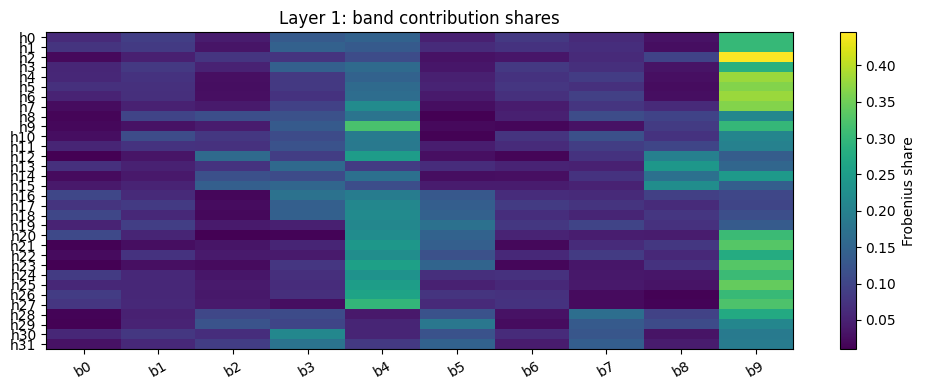

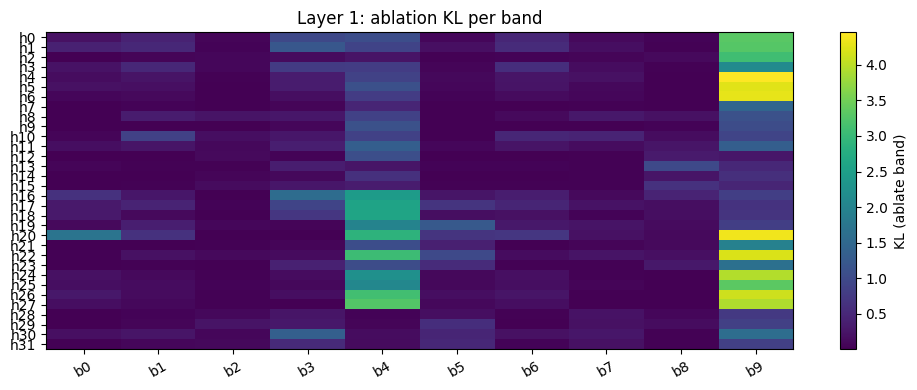

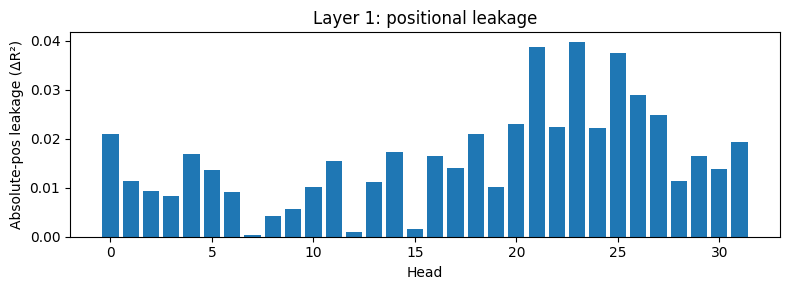

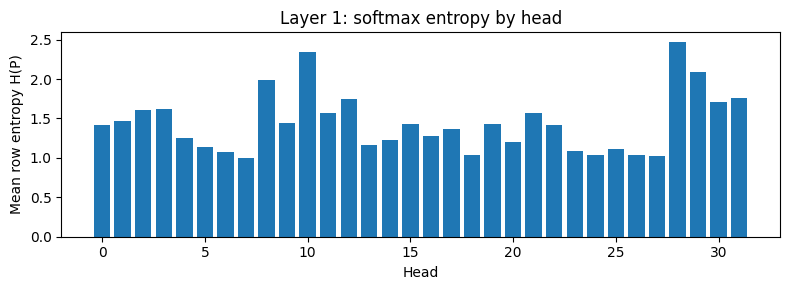

In [19]:
# === Step 10: plotting ===
import numpy as np
import matplotlib.pyplot as plt

def plot_band_share(results: dict, layer_idx: int):
    layer = results.get(layer_idx)
    if not layer:
        print(f"No results for layer {layer_idx}.")
        return
    if not layer[0].get("band_share_fro"):
        print(f"Layer {layer_idx} has no band shares.")
        return

    # Use a stable band order (sorted by band name)
    bands = sorted(layer[0]["band_share_fro"].keys())
    H = len(layer)
    mat = np.zeros((H, len(bands)), dtype=np.float32)
    for h, entry in enumerate(layer):
        for b, name in enumerate(bands):
            mat[h, b] = float(entry["band_share_fro"].get(name, 0.0))

    plt.figure(figsize=(10, 4))
    plt.imshow(mat, aspect='auto', interpolation='nearest')
    plt.yticks(range(H), [f"h{h}" for h in range(H)])
    plt.xticks(range(len(bands)), bands, rotation=30)
    plt.colorbar(label="Frobenius share")
    plt.title(f"Layer {layer_idx}: band contribution shares")
    plt.tight_layout()
    plt.show()

def plot_ablation_kl(results: dict, layer_idx: int):
    layer = results.get(layer_idx)
    if not layer or not layer[0].get("ablation_kl"):
        print(f"No ablation KLs for layer {layer_idx}.")
        return
    bands = sorted(layer[0]["ablation_kl"].keys())
    H = len(layer)
    mat = np.zeros((H, len(bands)), dtype=np.float32)
    for h, entry in enumerate(layer):
        for b, name in enumerate(bands):
            mat[h, b] = float(entry["ablation_kl"].get(name, np.nan))

    plt.figure(figsize=(10, 4))
    im = plt.imshow(mat, aspect='auto', interpolation='nearest')
    plt.yticks(range(H), [f"h{h}" for h in range(H)])
    plt.xticks(range(len(bands)), bands, rotation=30)
    plt.colorbar(im, label="KL (ablate band)")
    plt.title(f"Layer {layer_idx}: ablation KL per band")
    plt.tight_layout()
    plt.show()

def plot_leakage(leakage: dict, layer_idx: int):
    layer = leakage.get(layer_idx)
    if not layer:
        print(f"No leakage for layer {layer_idx}. Did you run Step 8?")
        return
    xs = [e.get("head", -1) for e in layer]
    ys = [float(e.get("leakage_abs", np.nan)) for e in layer]
    plt.figure(figsize=(8, 3))
    plt.bar(xs, ys)
    plt.xlabel("Head")
    plt.ylabel("Absolute-pos leakage (ΔR²)")
    plt.title(f"Layer {layer_idx}: positional leakage")
    plt.tight_layout()
    plt.show()

def plot_softmax_entropy(softmax_results: dict, layer_idx: int):
    layer = softmax_results.get(layer_idx)
    if not layer:
        print(f"No softmax diagnostics for layer {layer_idx}.")
        return
    H = len(layer)
    vals = np.array([row.get("softmax_diag", {}).get("H_mean", np.nan) for row in layer], dtype=np.float32)
    plt.figure(figsize=(8, 3))
    plt.bar(range(H), vals)
    plt.xlabel("Head")
    plt.ylabel("Mean row entropy H(P)")
    plt.title(f"Layer {layer_idx}: softmax entropy by head")
    plt.tight_layout()
    plt.show()

plot_band_share(results, layer_idx=1)
plot_ablation_kl(results, layer_idx=1)
plot_leakage(leakage, layer_idx=1)
plot_softmax_entropy(softmax_results, layer_idx=1)


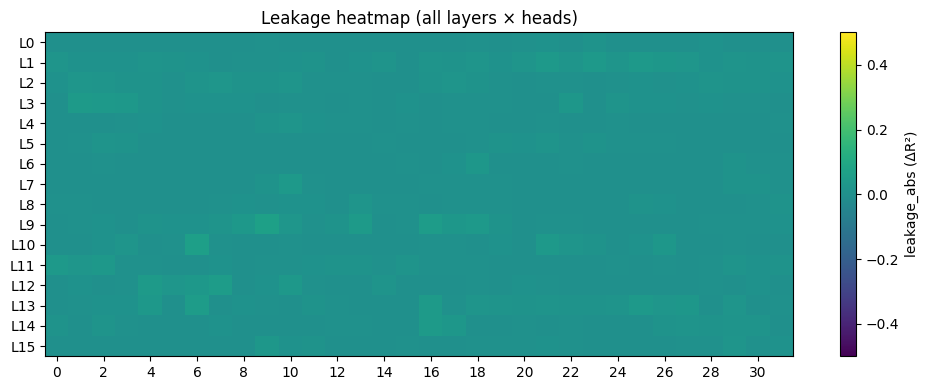

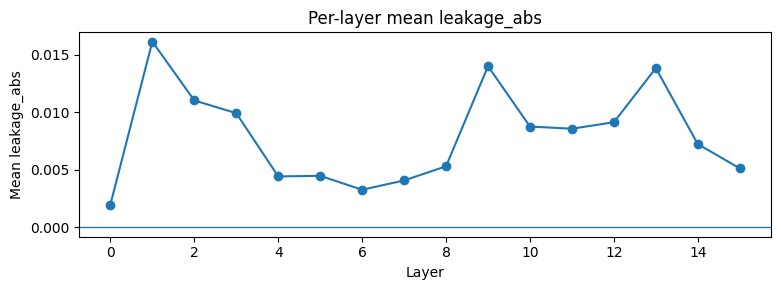

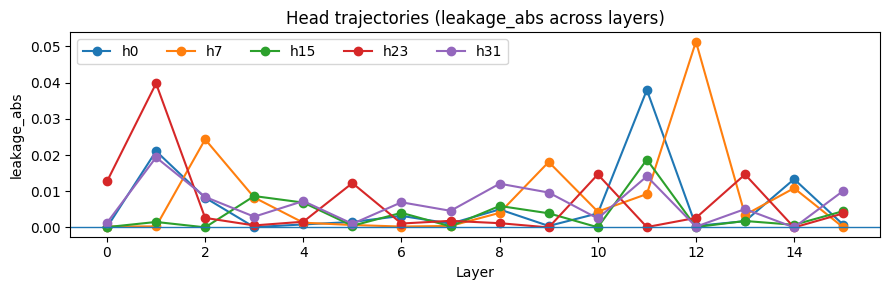

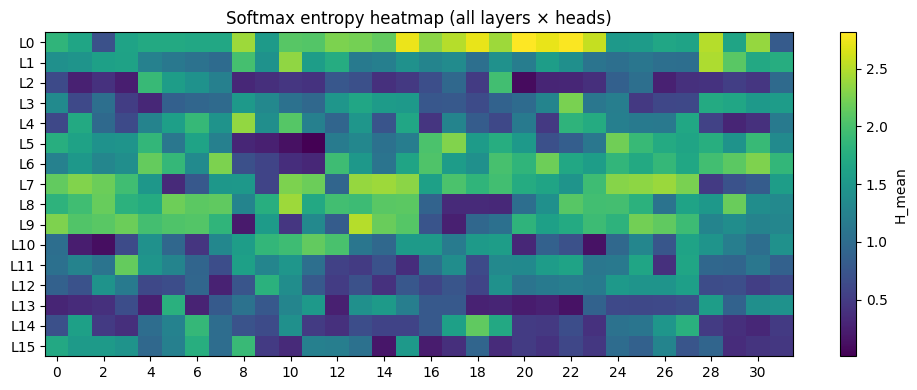

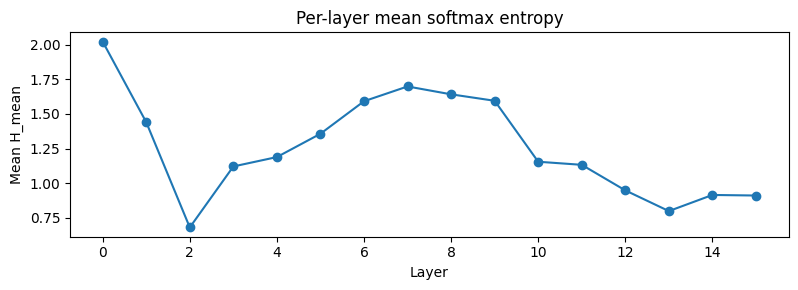

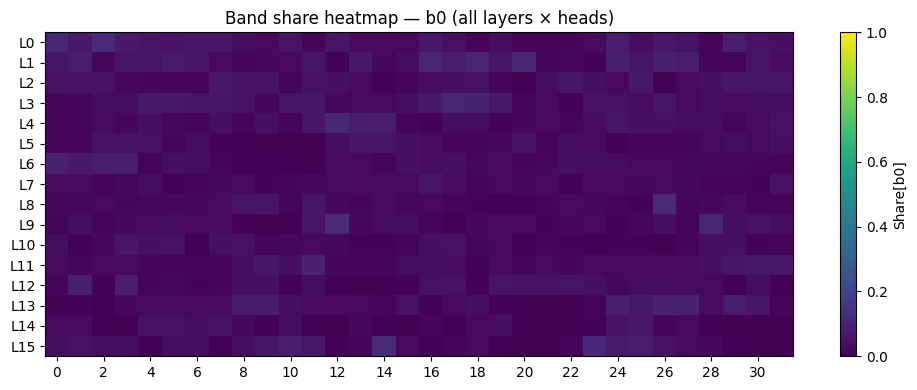

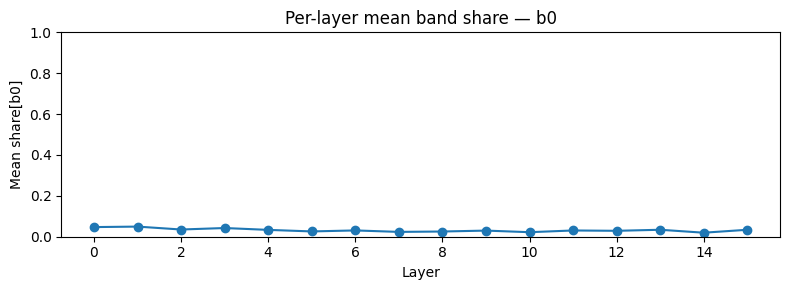

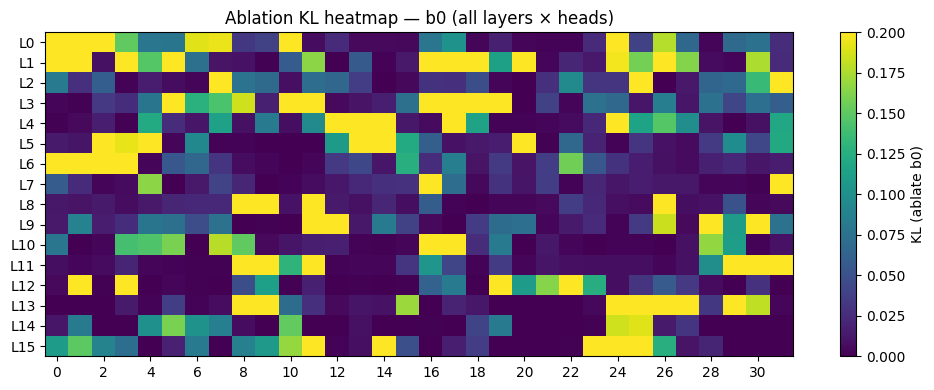

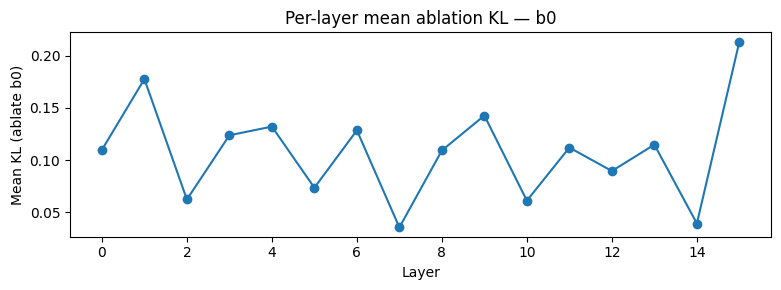

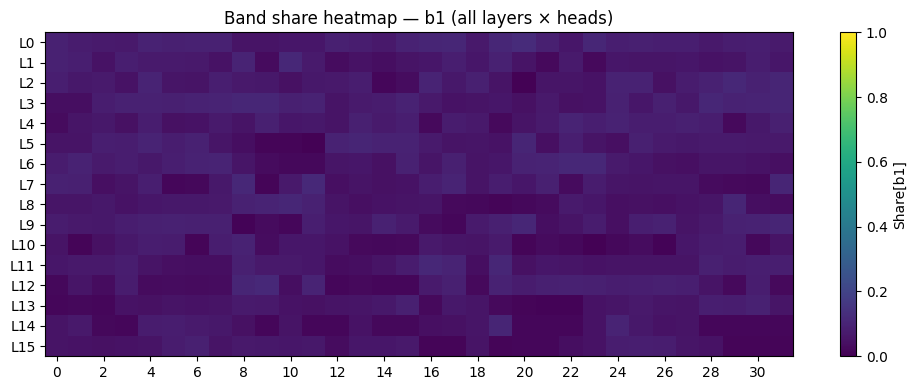

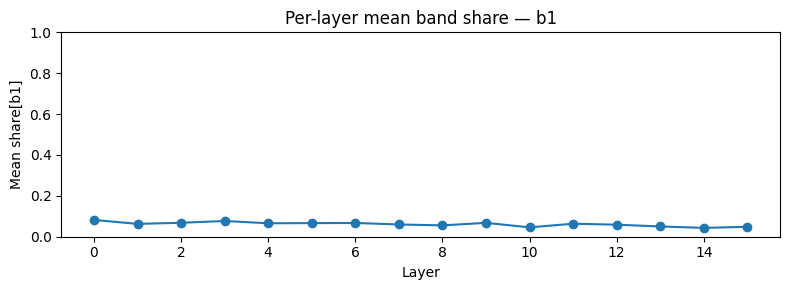

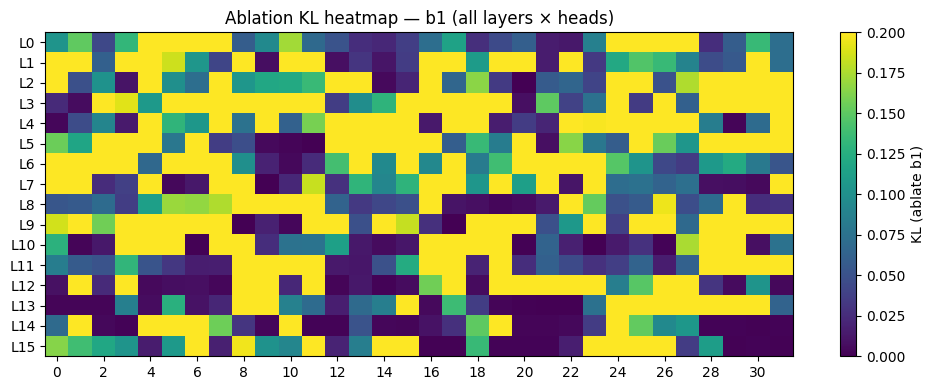

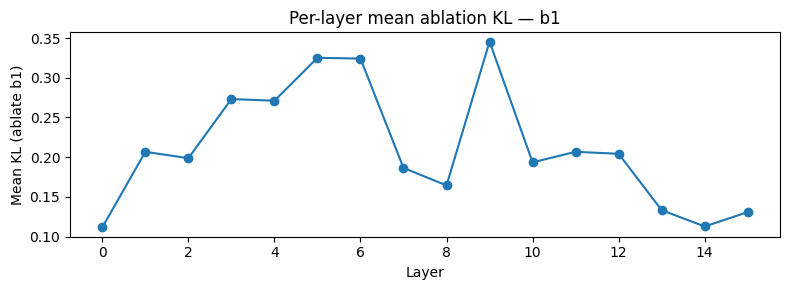

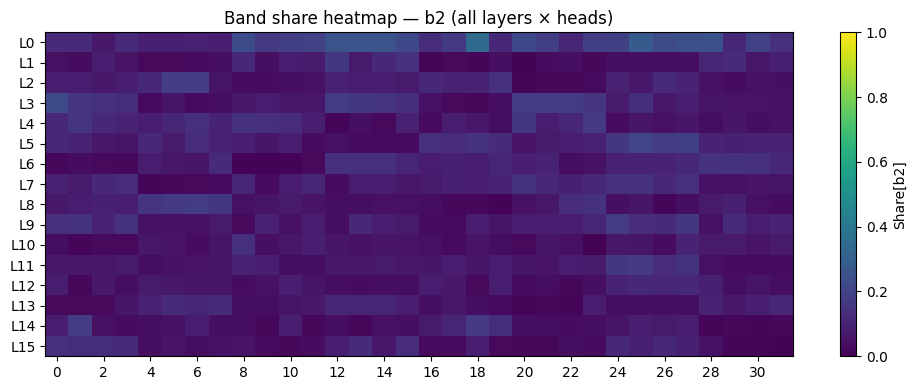

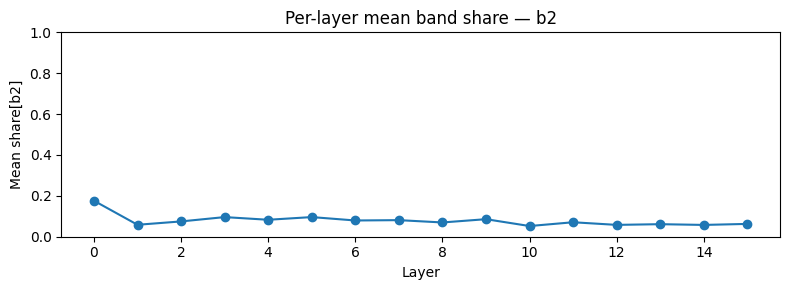

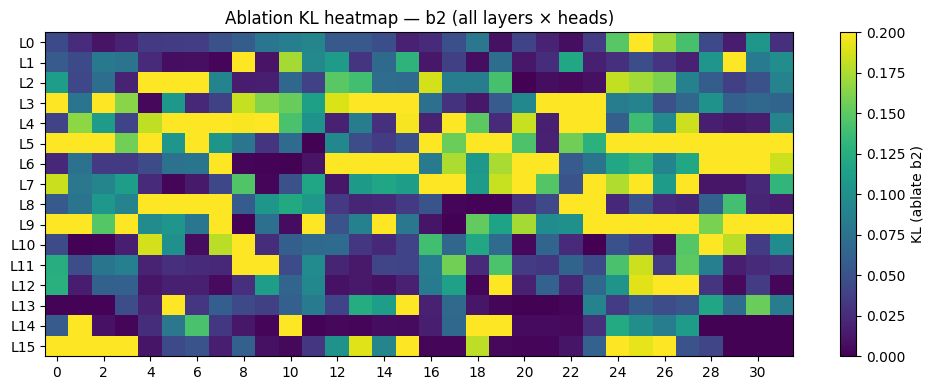

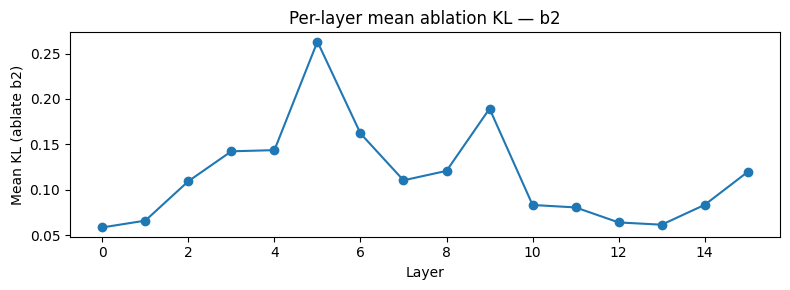

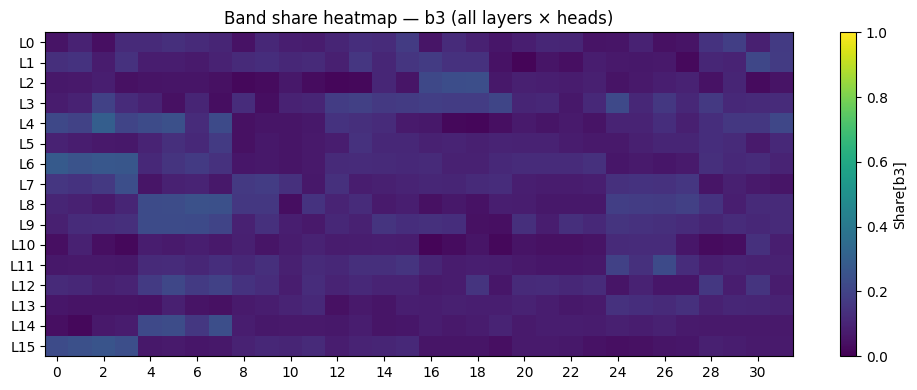

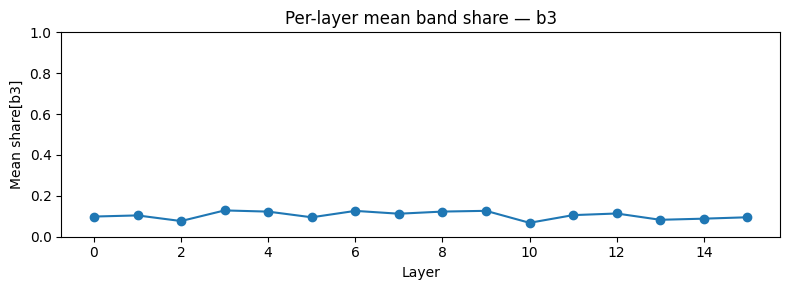

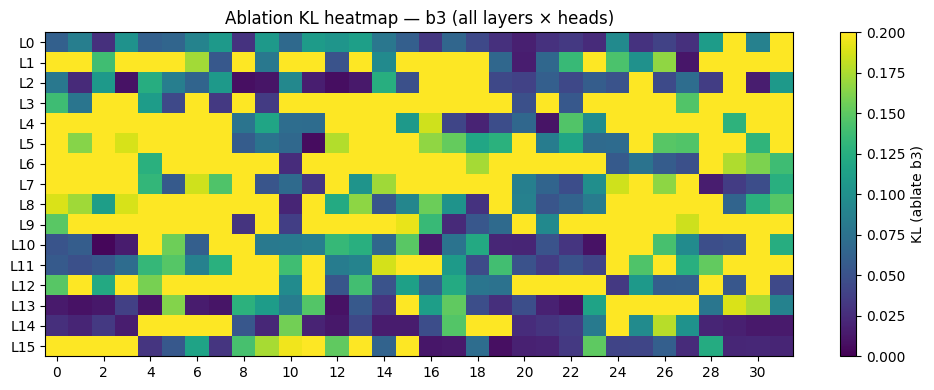

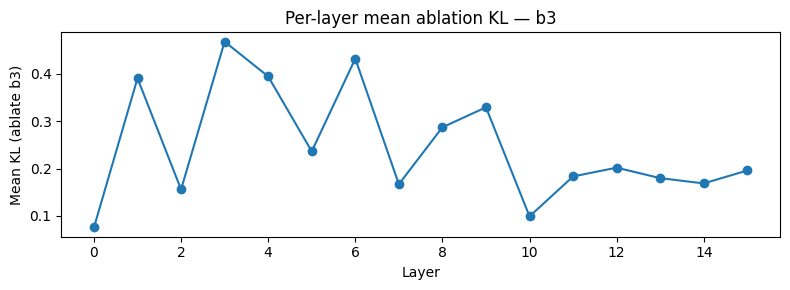

In [20]:
# === Step 10B: plotting ===

def _layers_heads_matrix(table: dict, key: str):
    """
    Build a (n_layers x max_heads) matrix from dict[layer]->list(rows),
    where each row has the field `key`.
    Returns (layers_sorted, M with NaNs for missing heads).
    """
    if not isinstance(table, dict) or not table:
        return [], np.zeros((0,0), dtype=np.float32)
    layers = sorted(table.keys())
    maxH = 0
    for li in layers:
        rows = table.get(li) or []
        if rows:
            maxH = max(maxH, max([r.get("head", -1) for r in rows]) + 1)
    if maxH == 0:
        return layers, np.zeros((len(layers), 0), dtype=np.float32)

    M = np.full((len(layers), maxH), np.nan, dtype=np.float32)
    for r, li in enumerate(layers):
        for row in (table.get(li) or []):
            h = int(row.get("head", -1))
            if 0 <= h < maxH and key in row and row[key] is not None:
                try:
                    M[r, h] = float(row[key])
                except Exception:
                    pass
    return layers, M

# Leakage (Step 8)

def plot_leakage_all_layers(leakage: dict, show_mean=True, vmax=None):
    """
    Heatmap of ΔR² (absolute-pos leakage) across all layers/heads + optional per-layer mean.
    """
    layers, M = _layers_heads_matrix(leakage, "leakage_abs")
    if M.size == 0:
        print("No leakage data to plot.")
        return
    plt.figure(figsize=(10, 4))
    im = plt.imshow(M, aspect='auto', interpolation='nearest',
                    vmin=(-vmax if vmax else None), vmax=(vmax if vmax else None))
    plt.colorbar(im, label="leakage_abs (ΔR²)")
    plt.yticks(range(len(layers)), [f"L{li}" for li in layers])
    plt.xticks(range(0, M.shape[1], max(1, (M.shape[1] // 16))))
    plt.title("Leakage heatmap (all layers × heads)")
    plt.tight_layout()
    plt.show()

    if show_mean:
        means = np.nanmean(M, axis=1)
        plt.figure(figsize=(8,3))
        plt.plot(layers, means, marker='o')
        plt.axhline(0, linewidth=1)
        plt.xlabel("Layer")
        plt.ylabel("Mean leakage_abs")
        plt.title("Per-layer mean leakage_abs")
        plt.tight_layout()
        plt.show()

def plot_leakage_head_trajectories(leakage: dict, head_indices=(0,1,2,3)):
    """
    Track same head indices across layers (useful if heads count is constant per layer).
    """
    layers, M = _layers_heads_matrix(leakage, "leakage_abs")
    if M.size == 0:
        print("⚠️ No leakage data to plot.")
        return
    plt.figure(figsize=(9,3))
    for h in head_indices:
        if h < M.shape[1]:
            plt.plot(layers, M[:,h], marker='o', label=f"h{h}")
    plt.axhline(0, linewidth=1)
    plt.xlabel("Layer"); plt.ylabel("leakage_abs")
    plt.title("Head trajectories (leakage_abs across layers)")
    plt.legend(ncol=min(len(head_indices), 6))
    plt.tight_layout(); plt.show()

# Softmax (Step 7B)

def plot_softmax_entropy_all_layers(softmax_results: dict, show_mean=True):
    """
    Heatmap of softmax mean row entropy across layers×heads + per-layer mean.
    """
    # convert the sidecar structure to the same shape: layer -> list of rows with "H_mean"
    sm_flat = {}
    for li, rows in (softmax_results or {}).items():
        sm_flat[li] = [{"head": r.get("head"), "H_mean": float(r.get("softmax_diag", {}).get("H_mean", np.nan))}
                       for r in rows]
    layers, M = _layers_heads_matrix(sm_flat, "H_mean")
    if M.size == 0:
        print("⚠️ No softmax diagnostics to plot.")
        return
    plt.figure(figsize=(10,4))
    im = plt.imshow(M, aspect='auto', interpolation='nearest')
    plt.colorbar(im, label="H_mean")
    plt.yticks(range(len(layers)), [f"L{li}" for li in layers])
    plt.xticks(range(0, M.shape[1], max(1, (M.shape[1] // 16))))
    plt.title("Softmax entropy heatmap (all layers × heads)")
    plt.tight_layout(); plt.show()

    if show_mean:
        means = np.nanmean(M, axis=1)
        plt.figure(figsize=(8,3))
        plt.plot(layers, means, marker='o')
        plt.xlabel("Layer"); plt.ylabel("Mean H_mean")
        plt.title("Per-layer mean softmax entropy")
        plt.tight_layout(); plt.show()

# Band shares & KL (Step 7)

def _collect_band_matrix(results: dict, band_name: str, field: str):
    """
    Build layers×heads matrix for a specific band:
      field = "band_share_fro" or "ablation_kl"
    """
    layers = sorted(results.keys())
    # determine max heads
    maxH = 0
    for li in layers:
        rows = results.get(li) or []
        if rows:
            maxH = max(maxH, max([r.get("head", -1) for r in rows]) + 1)
    if maxH == 0:
        return layers, np.zeros((0,0), dtype=np.float32)

    M = np.full((len(layers), maxH), np.nan, dtype=np.float32)
    for r, li in enumerate(layers):
        for row in (results.get(li) or []):
            h = int(row.get("head", -1))
            if 0 <= h < maxH:
                blob = row.get(field, {}) or {}
                if band_name in blob and blob[band_name] is not None:
                    try:
                        M[r, h] = float(blob[band_name])
                    except Exception:
                        pass
    return layers, M

def plot_band_share_all_layers(results: dict, band_name: str, show_mean=True):
    """
    Heatmap of band share (Fro) for a specific band across all layers×heads.
    """
    layers, M = _collect_band_matrix(results, band_name, field="band_share_fro")
    if M.size == 0:
        print(f"⚠️ No band shares found for band '{band_name}'.")
        return
    plt.figure(figsize=(10,4))
    im = plt.imshow(M, aspect='auto', interpolation='nearest', vmin=0.0, vmax=1.0)
    plt.colorbar(im, label=f"Share[{band_name}]")
    plt.yticks(range(len(layers)), [f"L{li}" for li in layers])
    plt.xticks(range(0, M.shape[1], max(1, (M.shape[1] // 16))))
    plt.title(f"Band share heatmap — {band_name} (all layers × heads)")
    plt.tight_layout(); plt.show()

    if show_mean:
        means = np.nanmean(M, axis=1)
        plt.figure(figsize=(8,3))
        plt.plot(layers, means, marker='o')
        plt.ylim(0, 1)
        plt.xlabel("Layer"); plt.ylabel(f"Mean share[{band_name}]")
        plt.title(f"Per-layer mean band share — {band_name}")
        plt.tight_layout(); plt.show()

def plot_ablation_kl_all_layers(results: dict, band_name: str, vmax=None, show_mean=True):
    """
    Heatmap of ablation KL for a given band across layers×heads.
    """
    layers, M = _collect_band_matrix(results, band_name, field="ablation_kl")
    if M.size == 0:
        print(f"⚠️ No ablation KLs found for band '{band_name}'.")
        return
    plt.figure(figsize=(10,4))
    im = plt.imshow(M, aspect='auto', interpolation='nearest',
                    vmin=0.0, vmax=(vmax if vmax else None))
    plt.colorbar(im, label=f"KL (ablate {band_name})")
    plt.yticks(range(len(layers)), [f"L{li}" for li in layers])
    plt.xticks(range(0, M.shape[1], max(1, (M.shape[1] // 16))))
    plt.title(f"Ablation KL heatmap — {band_name} (all layers × heads)")
    plt.tight_layout(); plt.show()

    if show_mean:
        means = np.nanmean(M, axis=1)
        plt.figure(figsize=(8,3))
        plt.plot(layers, means, marker='o')
        plt.xlabel("Layer"); plt.ylabel(f"Mean KL (ablate {band_name})")
        plt.title(f"Per-layer mean ablation KL — {band_name}")
        plt.tight_layout(); plt.show()


# 1) leakage (\DeltaR^2) across layers
plot_leakage_all_layers(leakage, show_mean=True, vmax=0.5)
plot_leakage_head_trajectories(leakage, head_indices=(0, 7, 15, 23, 31))

# 2) softmax entropy across layers
plot_softmax_entropy_all_layers(softmax_results, show_mean=True)

# 3) band shares & ablation KL across layers (pick a band key from your BAND_SLICES, e.g. 'b0')
plot_band_share_all_layers(results, band_name="b0", show_mean=True)
plot_ablation_kl_all_layers(results, band_name="b0", vmax=0.2, show_mean=True)


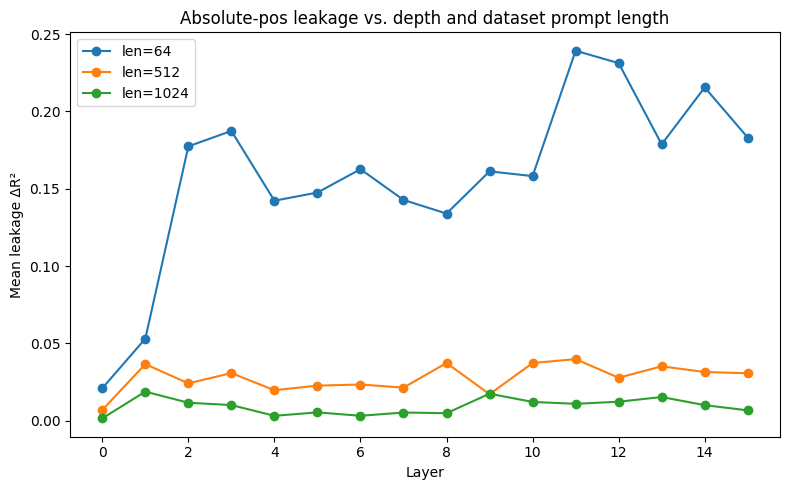

In [21]:
# Step Y: leakage vs. prompt length ---

from sklearn.linear_model import LinearRegression

def _model_device():
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")

device = _model_device()

# Local R^2 scorer
def r2(estimator, X, y):
    y_pred = estimator.predict(X)
    ss_res = float(np.sum((y - y_pred) ** 2))
    ss_tot = float(np.sum((y - np.mean(y)) ** 2)) + 1e-12
    return 1.0 - (ss_res / ss_tot)

prompt_lengths = [64, 512, 1024]
sweep_leakage = {}

with torch.no_grad():
    for L in prompt_lengths:
        prompt_text = " ".join(TEXTS)[:L]
        enc = tok(prompt_text, return_tensors="pt", add_special_tokens=False,
                  truncation=True, max_length=L)
        for k in enc:
            enc[k] = enc[k].to(device)

        # Run forward to populate TRACE
        TRACE.clear()
        _ = model(**enc, output_attentions=False, use_cache=False)

        # Recompute leakage dict
        leakage_L = {}
        n_layers = len(model.model.layers) if hasattr(model, "model") else len(model.layers)

        for li in range(n_layers):
            heads = get_layer_head_mats(li)
            if not heads:
                continue

            seq = heads[0].Q.shape[0]
            I, J, rel, src, tgt, ones = build_design(seq)

            layer_leak = []
            for hi, lh in enumerate(heads):
                Q = lh.Q.to(torch.float32)
                K = lh.K.to(torch.float32)
                logits = (Q @ K.T)

                y = logits[I, J].to(torch.float64).cpu().numpy().reshape(-1, 1)
                y = np.nan_to_num(y, copy=False)

                X_rel  = np.concatenate([rel, ones], axis=1).astype(np.float64)
                X_full = np.concatenate([rel, src, tgt, ones], axis=1).astype(np.float64)

                lr_rel  = LinearRegression().fit(X_rel,  y)
                lr_full = LinearRegression().fit(X_full, y)
                R2_rel  = r2(lr_rel,  X_rel,  y)
                R2_full = r2(lr_full, X_full, y)

                leak = float(R2_full - R2_rel)
                layer_leak.append(leak)

            leakage_L[li] = layer_leak

        sweep_leakage[L] = leakage_L

# Plot average leakage per layer vs. length
plt.figure(figsize=(8, 5))
for L, leakdict in sweep_leakage.items():
    layer_ids = sorted(leakdict.keys())
    if not layer_ids:
        continue
    avgs = [float(np.mean(leakdict[li])) if leakdict[li] else np.nan for li in layer_ids]
    plt.plot(layer_ids, avgs, marker='o', label=f"len={L}")
plt.xlabel("Layer")
plt.ylabel("Mean leakage ΔR²")
plt.legend()
plt.title("Absolute-pos leakage vs. depth and dataset prompt length")
plt.tight_layout()
plt.show()


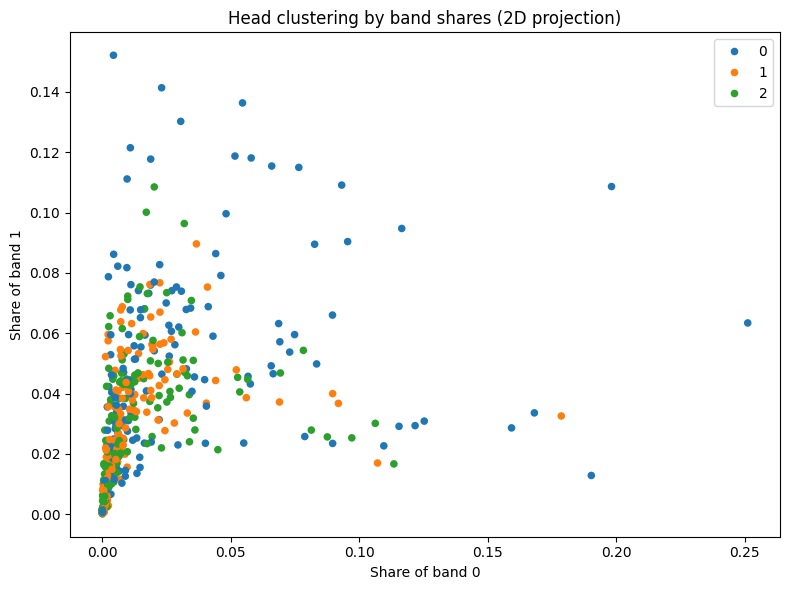

Cluster 0: 172 heads (e.g. [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)])
Cluster 1: 153 heads (e.g. [(1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 22), (1, 24), (1, 25)])
Cluster 2: 187 heads (e.g. [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)])


In [22]:
# --- Step Z: cluster heads by additive band shares ---
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def _effective_rotary_dim(head_dim: int) -> int:
    cfg = getattr(model, "config", None)
    try:
        rd, _spec = infer_rotary_dim(head_dim, cfg)
    except Exception:
        rd = head_dim
    if rd % 2 == 1:
        rd -= 1
    return max(2, min(rd, head_dim))

def additive_energy_shares(Q: torch.Tensor, K: torch.Tensor, dim_masks: dict[str, torch.Tensor]) -> dict[str, float]:
    # energy proxy per dim: ||q||^2 * ||k||^2 (separable upper bound on dot products)
    q2 = (Q.to(torch.float32)**2).sum(dim=0)   # [d]
    k2 = (K.to(torch.float32)**2).sum(dim=0)   # [d]
    e_dim = (q2 * k2).cpu().numpy()
    total = float(e_dim.sum()) + 1e-12
    shares = {}
    for name, dm in dim_masks.items():
        if dm.dtype != torch.bool:
            dm = dm.astype(bool) if hasattr(dm, "astype") else dm.to(torch.bool)
        shares[name] = float(e_dim[dm].sum() / total) if dm.sum() > 0 else 0.0
    return shares

all_shares = []
head_ids = []

with torch.no_grad():
    n_layers = len(model.model.layers) if hasattr(model, "model") and hasattr(model.model, "layers") else len(model.layers)
    for li in range(n_layers):
        mats = get_layer_head_mats(li)
        if not mats:
            continue
        hd = int(mats[0].Q.shape[1])
        # RoPE bands over rotated subspace only
        pair_masks = rope_band_masks(hd, BAND_SLICES, model=model)
        rotary_dim_eff = _effective_rotary_dim(hd)
        dim_masks = {
            name: pair_indices_to_dim_mask(pm, head_dim=hd, rotary_dim=rotary_dim_eff)
            for name, pm in pair_masks.items()
        }
        # Keep a stable band order across heads
        band_order = sorted(dim_masks.keys())

        for hi, lh in enumerate(mats):
            shares = additive_energy_shares(lh.Q, lh.K, dim_masks)
            all_shares.append([shares[b] for b in band_order])
            head_ids.append((li, hi))

# Cluster (skip if nothing collected)
if not all_shares:
    print(" No head shares collected. Did TRACE get populated and bands computed?")
else:
    X = np.array(all_shares, dtype=np.float32)
    # 3 clusters by default; tweak as needed
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0).fit(X)
    labels = kmeans.labels_

    # Simple 2D projection: plot the first two band dimensions
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="tab10", s=30, edgecolor="none")
    plt.xlabel("Share of band 0")
    plt.ylabel("Share of band 1")
    plt.title("Head clustering by band shares (2D projection)")
    plt.tight_layout()
    plt.show()

    for c in range(kmeans.n_clusters):
        members = [hid for hid, l in zip(head_ids, labels) if l == c]
        print(f"Cluster {c}: {len(members)} heads (e.g. {members[:8]})")


SOFTMAX PLOT

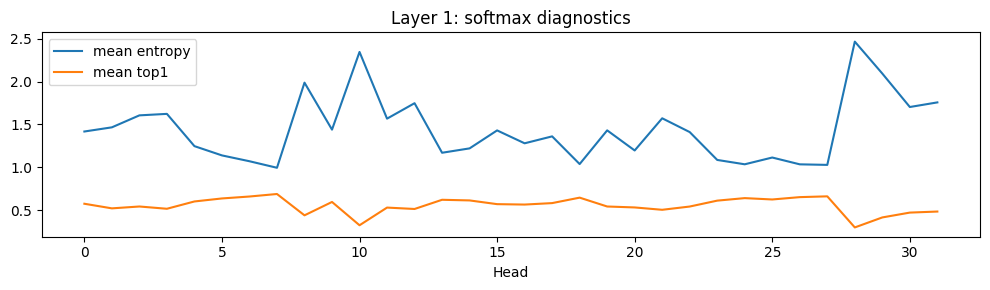

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_softmax_diag(softmax_results, layer_idx):
    layer = softmax_results.get(layer_idx, [])
    if not layer:
        print(f"[plot_softmax_diag] No data for layer {layer_idx}.")
        return
    xs = [e["head"] for e in layer]
    H = [e["softmax_diag"]["H_mean"] for e in layer]
    t1 = [e["softmax_diag"]["top1_mean"] for e in layer]
    plt.figure(figsize=(10,3))
    plt.plot(xs, H, label="mean entropy")
    plt.plot(xs, t1, label="mean top1")
    plt.xlabel("Head"); plt.title(f"Layer {layer_idx}: softmax diagnostics"); plt.legend(); plt.tight_layout(); plt.show()

plot_softmax_diag(softmax_results, layer_idx=1)


FFN ANALYSIS

In [24]:
# === Step F1: FFN capture (pre/post) ===
import torch
from contextlib import contextmanager

# layer_idx -> list of {"pre": [seq, d_model], "post": [seq, d_model]}
TRACE_FFN = {}

def _ffn_find_block(layer_idx):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return model.model.layers[layer_idx]
    if hasattr(model, "layers"):
        return model.layers[layer_idx]
    raise AttributeError("Could not find layers on model")

def _ffn_find_mlp(block):
    for name in ("mlp", "feed_forward", "ffn", "ffn_block"):
        if hasattr(block, name):
            return getattr(block, name)
    raise AttributeError("Could not find MLP/FFN module on this block.")

def _ffn_sanitize(x, to_cpu=True, dtype=torch.float32):
    # replace non-finite with 0, cast dtype, (optionally) move to CPU to save VRAM
    x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    x = x.to(dtype)
    return x.cpu() if to_cpu else x

def _ffn_forward_hook(layer_idx, *, to_cpu=True, keep_batch0=True):
    def hook(mod, inputs, output):
        # inputs: (hidden_states, ...)
        hs_pre = inputs[0]
        hs_post = output
        if keep_batch0:
            hs_pre = hs_pre[0]    # [seq, d_model]
            hs_post = hs_post[0]  # [seq, d_model]
        hs_pre  = _ffn_sanitize(hs_pre, to_cpu=to_cpu)
        hs_post = _ffn_sanitize(hs_post, to_cpu=to_cpu)

        TRACE_FFN.setdefault(layer_idx, []).append({"pre": hs_pre, "post": hs_post})
    return hook

@contextmanager
def ffn_capture_context(layers=None, *, to_cpu=True):
    """
    Register one forward hook per selected layer's MLP.
    - layers=None captures all layers.
    - to_cpu=True stores tensors on CPU to save VRAM.
    """
    hooks = []
    try:
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            L = len(model.model.layers)
        else:
            L = len(model.layers)
        target_layers = range(L) if layers is None else layers
        for li in target_layers:
            block = _ffn_find_block(li)
            mlp = _ffn_find_mlp(block)
            hooks.append(mlp.register_forward_hook(_ffn_forward_hook(li, to_cpu=to_cpu)))
        yield
    finally:
        for h in hooks:
            h.remove()

TRACE_FFN.clear()
with torch.no_grad(), ffn_capture_context():
    _ = model(**enc)
print({k: len(v) for k, v in TRACE_FFN.items()})


{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}


In [25]:
# === Step F2: FFN ablation ===
# Evaluates layers: first, q1, mid, q3, penultimate (L-2) so each has downstream signal.
# Ablates the same set. R^2 is clamped to [-1, 1] to avoid numeric spillover.

import math, torch
from dataclasses import dataclass
from contextlib import contextmanager
from tqdm.auto import tqdm

SEQ_CAP       = 256
HEADS_LIMIT   = None
PAIRS_SAMPLE  = 8000
DTYPE_MATMUL  = torch.bfloat16  # set to None to force fp32

@dataclass
class LayerHeadData:
    Q: torch.Tensor
    K: torch.Tensor

def _model_device():
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")

def _get_block(layer_idx):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return model.model.layers[layer_idx]
    if hasattr(model, "layers"):
        return model.layers[layer_idx]
    raise RuntimeError("Could not locate transformer layers on `model`.")

def _get_mlp_mod(block):
    if hasattr(block, "mlp"): return block.mlp
    for name in ("feed_forward","ffn","ffn_layer","ff"):
        if hasattr(block, name): return getattr(block, name)
    raise RuntimeError("Could not locate MLP/FFN submodule inside a block.")

def _zero_output_hook(mod, inputs, output):
    return torch.zeros_like(output)

@contextmanager
def ffn_zero_layer(layer_idx):
    block = _get_block(layer_idx)
    mlp = _get_mlp_mod(block)
    h = mlp.register_forward_hook(_zero_output_hook)
    try:
        yield
    finally:
        h.remove()

def _move_enc_to_device(enc_like, dev):
    for k in ("input_ids", "attention_mask", "token_type_ids", "position_ids"):
        if k in enc_like and enc_like[k] is not None:
            enc_like[k] = enc_like[k].to(dev)
    return enc_like

def _slice_enc_to_cap():
    """
    Trim enc/current_prompt to SEQ_CAP and move to model device.
    """
    dev = _model_device()
    if 'enc' in globals() and enc is not None:
        for k in ('input_ids', 'attention_mask'):
            if k in enc and enc[k] is not None:
                enc[k] = enc[k][:, :SEQ_CAP]
        _move_enc_to_device(enc, dev)
        return
    if 'current_prompt_text' in globals() and 'tok' in globals():
        e = tok(current_prompt_text, return_tensors="pt")
        for k in ('input_ids', 'attention_mask'):
            if k in e and e[k] is not None:
                e[k] = e[k][:, :SEQ_CAP]
        globals()['enc'] = _move_enc_to_device(e, dev)
        return
    raise RuntimeError("No input found. Provide `enc` or define `current_prompt_text` + `tok`.")

def _get_current_encoding():
    if 'enc' in globals() and enc is not None:
        dev = _model_device()
        _move_enc_to_device(enc, dev)
        ids = enc['input_ids']
        am  = enc.get('attention_mask', None)
        return ids, am
    raise RuntimeError("`enc` not found; call _slice_enc_to_cap() first.")

def _run_with_capture():
    if 'TRACE' not in globals():
        raise RuntimeError("TRACE dict not found. Make sure your RoPE hooks are installed.")
    TRACE.clear()
    input_ids, attn_mask = _get_current_encoding()
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attn_mask)

def get_layer_head_mats(layer_idx: int):
    """
    Returns List[LayerHeadData] for the last capture of a layer.
    Skips the layer if K is unavailable (some buggy hooks only captured q_rot).
    Handles GQA by repeating kv groups to match q heads.
    """
    entries = TRACE.get(layer_idx, None)
    if not entries:
        return []
    last = entries[-1]
    if ("q_rot" not in last) or ("k_rot" not in last):
        return []  # skip if we don't have both Q and K
    q = last["q_rot"]  # [bs, n_q, seq, hd]  (often stored on CPU by the hook)
    k = last["k_rot"]  # [bs, n_kv, seq, hd]
    bs, n_q, seq, hd = q.shape
    _, n_kv, _, _ = k.shape
    if n_kv == n_q:
        k_exp = k
    else:
        reps = max(1, n_q // n_kv)
        k_exp = k.repeat_interleave(reps, dim=1)[:, :n_q]
    out = []
    for h in range(n_q):
        Q = q[0, h, :seq, :].contiguous()
        K = k_exp[0, h, :seq, :].contiguous()
        out.append(LayerHeadData(Q=Q, K=K))
    return out

# leakage math (device-safe + R^2)
def _sample_causal_pairs(seq, n_pairs, *, on_device):
    i = torch.randint(low=0, high=seq, size=(n_pairs,), device=on_device)
    j = (torch.rand(size=(n_pairs,), device=on_device) * (i.to(torch.float32) + 1.0)).floor().to(torch.long)
    d = (i - j).to(torch.long)
    return i, j, d

def _clamp_r2(x):
    x = float(x)
    if math.isfinite(x):
        return max(min(x, 1.0), -1.0)
    return float('nan')

def _fast_leakage_from_logits(logits, i, j, d):
    # logits: [seq, seq]; i,j,d on same device
    y = logits[i, j].to(torch.float32)  # (N,)
    N = y.shape[0]
    seq = logits.shape[0]

    X = torch.zeros((N, seq), device=y.device, dtype=torch.float32)
    X[torch.arange(N, device=y.device), d] = 1.0

    # with intercept
    ones = torch.ones((N, 1), device=y.device)
    X1 = torch.cat([ones, X], dim=1)
    try:
        beta = torch.linalg.lstsq(X1, y).solution
    except RuntimeError:
        beta = torch.linalg.pinv(X1) @ y
    yhat = X1 @ beta
    ss_res = torch.sum((y - yhat) ** 2)
    ss_tot = torch.sum((y - torch.mean(y)) ** 2) + 1e-12
    R2_full = 1.0 - (ss_res / ss_tot)

    # no intercept
    try:
        beta_rel = torch.linalg.lstsq(X, y).solution
    except RuntimeError:
        beta_rel = torch.linalg.pinv(X) @ y
    yhat_rel = X @ beta_rel
    ss_res_rel = torch.sum((y - yhat_rel) ** 2)
    R2_rel = 1.0 - (ss_res_rel / ss_tot)

    R2_full = _clamp_r2(R2_full)
    R2_rel  = _clamp_r2(R2_rel)
    return R2_rel, R2_full, _clamp_r2(R2_full - R2_rel)

def _compute_head_leakage_fast(Q, K, pairs=None):
    """
    Q, K come from TRACE; in your setup they are typically on CPU.
    If so, we auto-force fp32 matmul (BF16 CPU matmul may be unsupported).
    """
    seq, hd = Q.shape
    scale = 1.0 / math.sqrt(hd)

    # choose dtype safely
    use_dtype = DTYPE_MATMUL
    if Q.device.type == "cpu" or K.device.type == "cpu":
        use_dtype = None  # avoid bf16 matmul on CPU

    QQ, KK = Q, K
    if use_dtype is not None:
        QQ = QQ.to(use_dtype)
        KK = KK.to(use_dtype)
    logits = (QQ @ KK.T).to(torch.float32) * scale  # keep logits in fp32

    # pairs on same device as logits
    if pairs is None:
        pairs = _sample_causal_pairs(seq, PAIRS_SAMPLE, on_device=logits.device)
    i, j, d = pairs
    if i.device != logits.device:
        i = i.to(logits.device); j = j.to(logits.device); d = d.to(logits.device)
    return _fast_leakage_from_logits(logits, i, j, d)

# main runners
def run_ffn_penultimate_on_last(seq_cap=256, heads_limit=None):
    """
    Ablate layer L-2 (penultimate) and evaluate leakage on layer L-1 (last).
    Returns: baseline_leakage, ffn_leakage with the usual shapes.
    """
    _slice_enc_to_cap()

    # layer count
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)
    if L < 2:
        raise RuntimeError("Model needs at least 2 layers for penultimate-on-last study.")

    abl_layer  = L - 2
    eval_layer = L - 1

    # baseline capture
    _run_with_capture()

    # pre-sample pairs on eval layer device/seq
    if eval_layer not in TRACE or len(TRACE[eval_layer]) == 0 or "q_rot" not in TRACE[eval_layer][-1]:
        raise RuntimeError("TRACE does not contain q_rot for the eval layer. Check your RoPE capture hooks.")
    entries = TRACE[eval_layer][-1]
    seq_len = entries["q_rot"].shape[2]
    dev     = entries["q_rot"].device
    pairs   = _sample_causal_pairs(min(seq_len, seq_cap), PAIRS_SAMPLE, on_device=dev)

    # baseline leakage on last
    baseline_leakage = {}
    heads = get_layer_head_mats(eval_layer)
    rows = []
    H = len(heads) if heads_limit is None else min(heads_limit, len(heads))
    for hi in range(H):
        Q, K = heads[hi].Q[:seq_cap], heads[hi].K[:seq_cap]
        R2_rel, R2_full, leakage_abs = _compute_head_leakage_fast(Q, K, pairs=pairs)
        rows.append({"head": hi, "R2_rel": R2_rel, "R2_full": R2_full, "leakage_abs": leakage_abs})
    baseline_leakage[eval_layer] = rows

    # ablate penultimate and re-evaluate last
    ffn_leakage = {}
    with ffn_zero_layer(abl_layer):
        _run_with_capture()
    heads = get_layer_head_mats(eval_layer)
    rows = []
    H = len(heads) if heads_limit is None else min(heads_limit, len(heads))
    for hi in range(H):
        Q, K = heads[hi].Q[:seq_cap], heads[hi].K[:seq_cap]
        R2_rel, R2_full, leakage_abs = _compute_head_leakage_fast(Q, K, pairs=pairs)
        rows.append({"head": hi, "R2_rel": R2_rel, "R2_full": R2_full, "leakage_abs": leakage_abs})
    ffn_leakage[abl_layer] = {eval_layer: rows}

    print("Penultimate-on-last ablation done.")
    print(f"   Ablated layer: {abl_layer}  |  Evaluated layer: {eval_layer}")
    print(f"   seq_cap={seq_cap}, heads_limit={heads_limit}, pairs_sample={PAIRS_SAMPLE}, matmul_dtype={DTYPE_MATMUL}")
    return baseline_leakage, ffn_leakage


def run_ffn_fast_ablation_targeted(use_penultimate=True):
    """
    Targeted fast sweep (first, q1, mid, q3, penultimate-or-last).
    Device safe, CPU-friendly. Compatible with TRACE captured on CPU.
    """
    _slice_enc_to_cap()

    # layer count
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)
    assert L >= 3, "Need at least 3 layers for penultimate evaluation."

    first = 0
    last  = L - 1
    mid   = L // 2
    q1    = (first + mid) // 2
    q3    = (mid + last) // 2

    eval_last = (L - 2) if use_penultimate else last
    eval_layers = sorted({first, q1, mid, q3, last})
    ablate_layers = sorted({first, q1, mid, q3, eval_last})

    # baseline capture
    _run_with_capture()

    # pre-sample pairs per eval layer (on that layer's device)
    pairs_by_layer = {}
    for li in eval_layers:
        if li not in TRACE or len(TRACE[li]) == 0 or "q_rot" not in TRACE[li][-1]:
            continue
        entries = TRACE[li][-1]
        seq_len = entries["q_rot"].shape[2]
        dev     = entries["q_rot"].device
        pairs_by_layer[li] = _sample_causal_pairs(min(seq_len, SEQ_CAP), PAIRS_SAMPLE, on_device=dev)

    # baseline leakage
    baseline_leakage = {}
    for li in tqdm(eval_layers, desc="Baseline leakage (target layers)"):
        if li not in pairs_by_layer:
            continue
        heads = get_layer_head_mats(li)
        if not heads:
            continue
        rows = []
        H = len(heads) if HEADS_LIMIT is None else min(HEADS_LIMIT, len(heads))
        for hi in range(H):
            Q, K = heads[hi].Q[:SEQ_CAP], heads[hi].K[:SEQ_CAP]
            R2_rel, R2_full, leakage_abs = _compute_head_leakage_fast(Q, K, pairs=pairs_by_layer[li])
            rows.append({"head": hi, "R2_rel": R2_rel, "R2_full": R2_full, "leakage_abs": leakage_abs})
        baseline_leakage[li] = rows

    # ablations
    ffn_leakage = {}
    for abl_li in tqdm(ablate_layers, desc="FFN ablation (per targeted layer)"):
        with ffn_zero_layer(abl_li):
            _run_with_capture()
        per_ablation = {}
        for li in eval_layers:
            if li not in pairs_by_layer:
                continue
            heads = get_layer_head_mats(li)
            if not heads:
                continue
            rows = []
            H = len(heads) if HEADS_LIMIT is None else min(HEADS_LIMIT, len(heads))
            for hi in range(H):
                Q, K = heads[hi].Q[:SEQ_CAP], heads[hi].K[:SEQ_CAP]
                R2_rel, R2_full, leakage_abs = _compute_head_leakage_fast(Q, K, pairs=pairs_by_layer[li])
                rows.append({"head": hi, "R2_rel": R2_rel, "R2_full": R2_full, "leakage_abs": leakage_abs})
            per_ablation[li] = rows
        ffn_leakage[abl_li] = per_ablation

    print("Fast FFN ablation done.")
    print(f"   Evaluated layers: {eval_layers}  (first, q1, mid, q3, {'penultimate' if use_penultimate else 'last'})")
    print(f"   Ablated layers:   {ablate_layers}")
    print(f"   seq_cap={SEQ_CAP}, heads_limit={HEADS_LIMIT}, pairs_sample={PAIRS_SAMPLE}, matmul_dtype={DTYPE_MATMUL}")
    return baseline_leakage, ffn_leakage

# (penultimate=True gives downstream signal for the deepest target)
baseline_leakage, ffn_leakage = run_ffn_fast_ablation_targeted(use_penultimate=True)

Baseline leakage (target layers):   0%|          | 0/5 [00:00<?, ?it/s]

FFN ablation (per targeted layer):   0%|          | 0/5 [00:00<?, ?it/s]

✅ Fast FFN ablation done.
   Evaluated layers: [0, 4, 8, 11, 15]  (first, q1, mid, q3, penultimate)
   Ablated layers:   [0, 4, 8, 11, 14]
   seq_cap=256, heads_limit=None, pairs_sample=8000, matmul_dtype=torch.bfloat16


In [26]:
def ffn_spectral_gain(TRACE_FFN, layer_idx):
    entries = TRACE_FFN.get(layer_idx, [])
    if not entries:
        return None, None

    # align seq lengths across passes
    min_seq = min(int(e["pre"].shape[0]) for e in entries)
    gains = []
    for e in entries:
        pre  = e["pre"][:min_seq]
        post = e["post"][:min_seq]
        pre  = torch.nan_to_num(pre,  nan=0.0, posinf=0.0, neginf=0.0)
        post = torch.nan_to_num(post, nan=0.0, posinf=0.0, neginf=0.0)
        pre  = pre - pre.mean(dim=0, keepdim=True)
        post = post - post.mean(dim=0, keepdim=True)

        PRE  = torch.fft.rfft(pre,  dim=0)
        POST = torch.fft.rfft(post, dim=0)
        p_pre  = (PRE.abs()**2).mean(dim=1) + 1e-12
        p_post = (POST.abs()**2).mean(dim=1) + 1e-12
        gains.append((p_post / p_pre).cpu().numpy())

    gains = np.stack(gains, axis=0).mean(axis=0)
    freqs = np.linspace(0, 0.5, num=gains.shape[0])  # normalized Nyquist
    return freqs, gains


In [27]:
import numpy as np

def _index_layer(leak_dict):
    # leak_dict[layer] -> list of {"head","R2_rel","R2_full","leakage_abs"}
    return {li: {row["head"]: row for row in rows} for li, rows in leak_dict.items()}

def summarize_ffn_ablation_downstream(
    baseline_leakage,
    ffn_leakage,
    *,
    downstream_only=True,   # True -> only e > a; False -> include e == a as well
    eps=1e-4                # ignore tiny numerical jitter
):
    """
    Returns:
      per_ablation[a] = {
         'per_eval': {
             e: {'stats': [per-head deltas], 'mean_*', 'n_heads'}
         },
         'rolled': {'mean_* over all selected eval layers', 'n_pairs'}
      }
    """
    base_idx = _index_layer(baseline_leakage)
    per_ablation = {}

    ablated_layers = sorted(ffn_leakage.keys())
    for a in ablated_layers:
        # ffn_leakage[a] -> dict eval_layer -> list(rows)
        abl_eval = ffn_leakage[a]
        eval_layers = sorted(abl_eval.keys())

        per_eval = {}
        all_deltas = []

        for e in eval_layers:
            if downstream_only and not (e > a):
                continue

            base_e = base_idx.get(e, {})
            abl_e  = _index_layer(abl_eval)[e]  # dict head->row for eval layer e

            h_ids = sorted(set(base_e.keys()) & set(abl_e.keys()))
            if not h_ids:
                continue

            deltas = []
            for h in h_ids:
                b = base_e[h]
                d_full = abl_e[h]["R2_full"]    - b["R2_full"]
                d_rel  = abl_e[h]["R2_rel"]     - b["R2_rel"]
                d_leak = abl_e[h]["leakage_abs"] - b["leakage_abs"]
                deltas.append({
                    "head": h,
                    "dR2_full":  d_full,
                    "dR2_rel":   d_rel,
                    "dLeak_abs": d_leak,
                    "base_leak": b["leakage_abs"],
                })

            if deltas:
                per_eval[e] = {
                    "stats": deltas,
                    "mean_dR2_full": float(np.nanmean([x["dR2_full"]  for x in deltas])),
                    "mean_dR2_rel":  float(np.nanmean([x["dR2_rel"]   for x in deltas])),
                    "mean_dLeak":    float(np.nanmean([x["dLeak_abs"] for x in deltas])),
                    "n_heads": len(deltas),
                }
                all_deltas.extend(deltas)

        rolled = None
        if all_deltas:
            rolled = {
                "mean_dR2_full": float(np.nanmean([x["dR2_full"]  for x in all_deltas])),
                "mean_dR2_rel":  float(np.nanmean([x["dR2_rel"]   for x in all_deltas])),
                "mean_dLeak":    float(np.nanmean([x["dLeak_abs"] for x in all_deltas])),
                "n_pairs": len(all_deltas),
            }

        per_ablation[a] = {"per_eval": per_eval, "rolled": rolled}

    # pretty print
    print(f"FFN ablation summary (downstream_only={downstream_only}, eps={eps}):")
    for a in sorted(per_ablation.keys()):
        rolled = per_ablation[a]["rolled"]
        if rolled is None:
            print(f"Layer {a:2d}: no overlapping heads with baseline in downstream eval layers.")
            continue
        print(f"Layer {a:2d} (ablated) | over downstream eval layers "
              f"| mean ΔR²_full={rolled['mean_dR2_full']:+.4f} "
              f"| mean ΔR²_rel={rolled['mean_dR2_rel']:+.4f} "
              f"| mean Δleak={rolled['mean_dLeak']:+.4f} "
              f"| pairs={rolled['n_pairs']}")

        # highlight per-eval layers with noticeable effect
        for e in sorted(per_ablation[a]["per_eval"].keys()):
            s = per_ablation[a]["per_eval"][e]
            if (abs(s["mean_dLeak"]) > eps) or (abs(s["mean_dR2_full"]) > eps) or (abs(s["mean_dR2_rel"]) > eps):
                print(f"  ↳ affects eval layer {e:2d}: "
                      f"ΔR²_full={s['mean_dR2_full']:+.4f}, "
                      f"ΔR²_rel={s['mean_dR2_rel']:+.4f}, "
                      f"Δleak={s['mean_dLeak']:+.4f} (n_heads={s['n_heads']})")
    return per_ablation

ffn_summary = summarize_ffn_ablation_downstream(
    baseline_leakage, ffn_leakage, downstream_only=True, eps=1e-4
)

FFN ablation summary (downstream_only=True, eps=0.0001):
Layer  0 (ablated) | over downstream eval layers | mean ΔR²_full=+0.1779 | mean ΔR²_rel=+0.2001 | mean Δleak=-0.0221 | pairs=128
  ↳ affects eval layer  4: ΔR²_full=+0.2673, ΔR²_rel=+0.2963, Δleak=-0.0290 (n_heads=32)
  ↳ affects eval layer  8: ΔR²_full=+0.0704, ΔR²_rel=+0.0912, Δleak=-0.0208 (n_heads=32)
  ↳ affects eval layer 11: ΔR²_full=+0.1570, ΔR²_rel=+0.1971, Δleak=-0.0401 (n_heads=32)
  ↳ affects eval layer 15: ΔR²_full=+0.2171, ΔR²_rel=+0.2157, Δleak=+0.0014 (n_heads=32)
Layer  4 (ablated) | over downstream eval layers | mean ΔR²_full=-0.0351 | mean ΔR²_rel=-0.0841 | mean Δleak=+0.0490 | pairs=96
  ↳ affects eval layer  8: ΔR²_full=-0.0573, ΔR²_rel=-0.0712, Δleak=+0.0139 (n_heads=32)
  ↳ affects eval layer 11: ΔR²_full=-0.0330, ΔR²_rel=-0.1048, Δleak=+0.0717 (n_heads=32)
  ↳ affects eval layer 15: ΔR²_full=-0.0148, ΔR²_rel=-0.0763, Δleak=+0.0615 (n_heads=32)
Layer  8 (ablated) | over downstream eval layers | mean ΔR²_ful

In [28]:
# === Multi-prompt FFN ablation significance: GRID over ablated x eval layers ===
# Uses paired tests across prompts + BH-FDR per (ablated_layer, eval_layer).
# Reuses the same prompts and the same (i,j,d) pairs PER prompt & eval layer for baseline vs ablated.

import math, numpy as np, torch
from tqdm.auto import tqdm

# BH-FDR + paired tests
def _bh_fdr(pvals, alpha=0.05):
    pvals = np.asarray(pvals, dtype=np.float64)
    n = pvals.size
    order = np.argsort(pvals)
    ranks = np.arange(1, n+1, dtype=np.float64)
    adj = np.empty_like(pvals)
    adj[order] = np.minimum.accumulate((pvals[order] * n / ranks)[::-1])[::-1]
    adj = np.clip(adj, 0.0, 1.0)
    sig = adj <= alpha
    return adj, sig

def _paired_t_pvalue(x, y):
    """Two-sided paired t-test; returns p. Falls back to sign-flip permutation if SciPy unavailable."""
    try:
        from scipy.stats import ttest_rel
        return float(ttest_rel(x, y, nan_policy="omit").pvalue)
    except Exception:
        d = np.asarray(x, dtype=np.float64) - np.asarray(y, dtype=np.float64)
        d = d[np.isfinite(d)]
        n = d.shape[0]
        if n == 0:
            return 1.0
        obs = abs(np.mean(d))
        R = 4000 if n <= 64 else 2000
        rng = np.random.default_rng(0)
        count = 0
        for _ in range(R):
            signs = rng.choice([-1.0, 1.0], size=n)
            boot = abs(np.mean(signs * d))
            if boot >= obs:
                count += 1
        return float((count + 1) / (R + 1))

# encoding + forward
def _encode_text(text, max_len, device):
    enc = tok(
        text, return_tensors="pt", truncation=True,
        max_length=max_len, add_special_tokens=False
    )
    for k in enc: enc[k] = enc[k].to(device)
    return enc

def _set_enc_and_forward(text, max_len):
    """Set global enc → _run_with_capture()."""
    global enc
    device = next(model.parameters()).device
    enc = _encode_text(text, max_len, device)
    _run_with_capture()

# pairs + metrics
def _eval_layer_pairs(eval_layer, seq_cap):
    """After a forward pass, sample causal pairs for the eval layer on correct device."""
    entries = TRACE.get(eval_layer, None)
    if not entries:
        raise RuntimeError(f"No TRACE entries for eval layer {eval_layer}. Check hooks/forward.")
    q = entries[-1]["q_rot"]
    seq = q.shape[2]
    dev = q.device
    S = min(seq_cap, seq)
    i = torch.randint(low=0, high=S, size=(4000,), device=dev)
    j = (torch.rand(size=(4000,), device=dev) * (i.to(torch.float32) + 1.0)).floor().to(torch.long)
    d = (i - j).to(torch.long)
    return (i, j, d)

def _per_head_metrics(eval_layer, seq_cap, pairs, metric):
    """Return metric per head for current TRACE."""
    heads = get_layer_head_mats(eval_layer)
    if not heads:
        return []
    vals = []
    for h in range(len(heads)):
        Q = heads[h].Q[:seq_cap]; K = heads[h].K[:seq_cap]
        R2_rel, R2_full, leak = _compute_head_leakage_fast(Q, K, pairs=pairs)
        if metric == "R2_full":
            vals.append(float(R2_full))
        elif metric == "R2_rel":
            vals.append(float(R2_rel))
        else:
            vals.append(float(leak))
    return vals

# grid driver
def ffn_multi_prompt_grid_significance(
    *,
    ablated_layers=None,      # list[int] or None → default {0, q1, mid, q3, L-2}
    eval_layers=None,         # list[int] or None → default {q1, mid, q3, L-1}
    metric="leakage_abs",     # "leakage_abs" | "R2_full" | "R2_rel"
    n_prompts=24,
    max_len=None,             # None -> SEQ_CAP or 256
    alpha=0.05,
    seed=0,
    prompt_selector="sequential"  # "sequential" | "random"
):
    """
    Returns:
      results: dict[(abl_layer, eval_layer)] -> list[rows per head]
               where each row has mean_delta, CI, p, q, significant, etc.
    Also prints a summary per (abl, eval) pair.
    """
    # layer range
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)
    if L < 2:
        raise RuntimeError("Model needs at least 2 layers.")

    # defaults
    if max_len is None:
        max_len = int(globals().get("SEQ_CAP", 256))

    first, last = 0, L - 1
    mid = L // 2
    q1 = (first + mid) // 2
    q3 = (mid + last) // 2

    if ablated_layers is None:
        ablated_layers = sorted({first, q1, mid, q3, L - 2})
    if eval_layers is None:
        eval_layers = sorted({q1, mid, q3, L - 1})

    # prompts
    assert "TEXTS" in globals() and len(TEXTS) > 0, "TEXTS not found. Load your dataset first."
    rng = np.random.default_rng(seed)
    if prompt_selector == "random":
        idxs = rng.choice(len(TEXTS), size=min(n_prompts, len(TEXTS)), replace=False)
    else:
        idxs = np.arange(min(n_prompts, len(TEXTS)))

    device = next(model.parameters()).device

    # storage:
    # base_metrics[(prompt_idx, eval_layer)] = list[metric per head]
    # pairs_store[(prompt_idx, eval_layer)] = (i,j,d)
    base_metrics = {}
    pairs_store = {}

    # pass 1: baseline for all prompts; cache per eval_layer metrics + pairs
    for t_idx in tqdm(idxs, desc="Baseline prompts"):
        text = str(TEXTS[int(t_idx)])
        _set_enc_and_forward(text, max_len)
        for e in eval_layers:
            pairs = _eval_layer_pairs(e, max_len)
            vals  = _per_head_metrics(e, max_len, pairs, metric)
            base_metrics[(int(t_idx), e)] = vals
            pairs_store[(int(t_idx), e)] = pairs

    # Result container
    results = {}

    # grid over ablated layers
    for a in ablated_layers:
        # For each prompt: run ablated once, then compute metrics for ALL eval layers using cached pairs
        # Collect per-head deltas per eval layer
        deltas_per_eval = {}   # e -> list[list_of_deltas_per_head]; outer size == n_prompts
        # Initialize once we know number of heads (from first e)
        heads_count_by_eval = {}

        for t_idx in tqdm(idxs, desc=f"Ablate L{a}", leave=False):
            text = str(TEXTS[int(t_idx)])

            # ablated forward for this prompt
            # (we need a forward per prompt per ablated layer, but only one per set of eval layers)
            global enc
            enc = _encode_text(text, max_len, device)
            with ffn_zero_layer(a):
                _run_with_capture()

            for e in eval_layers:
                pairs = pairs_store[(int(t_idx), e)]
                abl_vals = _per_head_metrics(e, max_len, pairs, metric)
                base_vals = base_metrics[(int(t_idx), e)]

                if e not in heads_count_by_eval:
                    heads_count_by_eval[e] = len(abl_vals)
                    deltas_per_eval[e] = [[] for _ in range(len(abl_vals))]  # per-head lists

                H = min(len(abl_vals), len(base_vals))
                for h in range(H):
                    deltas_per_eval[e][h].append(float(abl_vals[h] - base_vals[h]))

        # stats per eval layer (independent FDR per eval layer)
        for e in eval_layers:
            per_head = deltas_per_eval.get(e, None)
            if per_head is None or len(per_head) == 0:
                continue

            rows = []
            pvals = []
            for h, dlist in enumerate(per_head):
                d = np.asarray(dlist, dtype=np.float64)  # length = n_prompts
                y = d + base_metrics[(int(idxs[0]), e)][h]  # not used; keep paired test on deltas directly
                x = np.zeros_like(d)                       # placeholder; we pass d vs 0 via paired t on (y,x) structure
                # We want paired test on \Delta != 0; implement by comparing y (abl) vs x (base) shifted:
                p = _paired_t_pvalue(d, np.zeros_like(d))
                pvals.append(p)
                mu = float(np.mean(d))
                sd = float(np.std(d, ddof=1)) if len(d) > 1 else float("nan")
                lo, hi = (float("nan"), float("nan"))
                if len(d) >= 4:
                    lo, hi = np.percentile(d, [2.5, 97.5])
                eff = float(mu / sd) if (sd > 0 and math.isfinite(sd)) else float("nan")
                rows.append({
                    "ablated_layer": a,
                    "eval_layer": e,
                    "head": h,
                    "metric": metric,
                    "mean_delta": mu,
                    "ci_low": float(lo),
                    "ci_high": float(hi),
                    "std_delta": sd,
                    "p": float(p),
                    "cohen_d": eff,
                    "n_prompts": int(len(d)),
                })

            q, sig = _bh_fdr(np.array(pvals, dtype=np.float64), alpha=alpha)
            for r, qv, s in zip(rows, q, sig):
                r["q_fdr"] = float(qv)
                r["significant"] = bool(s)
                r["alpha_fdr"] = float(alpha)

            # store + print compact summary
            results[(a, e)] = rows
            k_sig = sum(r["significant"] for r in rows)
            H = len(rows)
            print(f"\n=== Multi-prompt FFN (metric={metric}) | Abl L{a} → Eval L{e} ===")
            print(f"n_prompts={len(idxs)}, max_len={max_len}, FDR α={alpha}")
            print(f"{k_sig}/{H} heads significant at FDR α={alpha} (BH).")
            top = sorted(rows, key=lambda r: r["q_fdr"])[:10]
            print("Top 10 heads by q (FDR):")
            for r in top:
                print(f"  H {r['head']:2d} | Δ={r['mean_delta']:+.4f} "
                      f"[{r['ci_low']:+.4f},{r['ci_high']:+.4f}]  p={r['p']:.4g}  q={r['q_fdr']:.4g}  n={r['n_prompts']}")

    return results

# 1) Default grid (ablated = {0,q1,mid,q3,L-2}, eval = {q1,mid,q3,L-1}), leakage:
grid_results = ffn_multi_prompt_grid_significance(metric="leakage_abs", n_prompts=24)

# 2) Custom: ablate several layers and evaluate on last+penultimate:
L = len(model.model.layers) if hasattr(model, "model") else len(model.layers)
grid_results = ffn_multi_prompt_grid_significance(
    ablated_layers=[L-3, L-2, 8], eval_layers=[L-2, L-1], metric="R2_full", n_prompts=24
)


Baseline prompts:   0%|          | 0/24 [00:00<?, ?it/s]

Ablate L0:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=leakage_abs) | Abl L0 → Eval L4 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  3 | Δ=-0.0437 [-0.4426,+0.0000]  p=0.2319  q=0.6184  n=24
  H  4 | Δ=-0.0573 [-0.5901,+0.0542]  p=0.1341  q=0.6184  n=24
  H  7 | Δ=-0.0207 [-0.2559,+0.0117]  p=0.1935  q=0.6184  n=24
  H  8 | Δ=-0.0508 [-0.6059,+0.0024]  p=0.1648  q=0.6184  n=24
  H 11 | Δ=-0.0791 [-0.8653,+0.0000]  p=0.1354  q=0.6184  n=24
  H 14 | Δ=-0.1218 [-1.4250,+0.0899]  p=0.2002  q=0.6184  n=24
  H 18 | Δ=+0.0233 [-0.0094,+0.2758]  p=0.2047  q=0.6184  n=24
  H 19 | Δ=-0.0662 [-0.6177,+0.0015]  p=0.1528  q=0.6184  n=24
  H 25 | Δ=-0.0574 [-0.7764,+0.1030]  p=0.2314  q=0.6184  n=24
  H 26 | Δ=+0.0205 [-0.0081,+0.2457]  p=0.1922  q=0.6184  n=24

=== Multi-prompt FFN (metric=leakage_abs) | Abl L0 → Eval L8 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  0 | Δ=-0.0458 [-0.480

Ablate L4:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=leakage_abs) | Abl L4 → Eval L4 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0198 [-0.2228,+0.0027]  p=0.2114  q=0.7389  n=24
  H  4 | Δ=-0.0263 [-0.4030,+0.1111]  p=0.3874  q=0.7389  n=24
  H  5 | Δ=-0.0777 [-0.7666,+0.0000]  p=0.1185  q=0.7389  n=24
  H  6 | Δ=+0.0070 [-0.0000,+0.0713]  p=0.2215  q=0.7389  n=24
  H  7 | Δ=-0.0293 [-0.2917,+0.0117]  p=0.133  q=0.7389  n=24
  H  8 | Δ=-0.0549 [-0.6164,+0.0024]  p=0.1391  q=0.7389  n=24
  H  9 | Δ=-0.0085 [-0.1059,+0.0148]  p=0.3465  q=0.7389  n=24
  H 13 | Δ=+0.0725 [-0.3022,+1.1874]  p=0.3665  q=0.7389  n=24
  H 15 | Δ=-0.0134 [-0.1565,+0.0038]  p=0.2032  q=0.7389  n=24
  H 16 | Δ=-0.0904 [-1.0000,+0.0000]  p=0.1303  q=0.7389  n=24

=== Multi-prompt FFN (metric=leakage_abs) | Abl L4 → Eval L8 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  0 | Δ=-0.0172 [-0.1631

Ablate L8:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=leakage_abs) | Abl L8 → Eval L4 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  0 | Δ=-0.0079 [-0.1696,+0.0897]  p=0.6564  q=0.9992  n=24
  H  1 | Δ=+0.0012 [-0.0567,+0.0637]  p=0.8671  q=0.9992  n=24
  H  2 | Δ=-0.0105 [-0.2532,+0.1609]  p=0.7027  q=0.9992  n=24
  H  3 | Δ=+0.0319 [-0.1036,+0.4154]  p=0.4509  q=0.9992  n=24
  H  4 | Δ=-0.0038 [-0.2766,+0.2024]  p=0.9042  q=0.9992  n=24
  H  5 | Δ=-0.0398 [-0.7666,+0.2809]  p=0.4742  q=0.9992  n=24
  H  6 | Δ=+0.0138 [-0.0000,+0.1552]  p=0.1583  q=0.9992  n=24
  H  7 | Δ=-0.0076 [-0.0927,+0.0171]  p=0.4217  q=0.9992  n=24
  H  8 | Δ=-0.0347 [-0.3705,+0.0024]  p=0.2605  q=0.9992  n=24
  H  9 | Δ=-0.0334 [-0.3267,+0.0000]  p=0.1552  q=0.9992  n=24

=== Multi-prompt FFN (metric=leakage_abs) | Abl L8 → Eval L8 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0143 [-0.135

Ablate L11:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=leakage_abs) | Abl L11 → Eval L4 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0092 [-0.1300,+0.0433]  p=0.326  q=0.8237  n=24
  H  2 | Δ=-0.0108 [-0.2054,+0.1001]  p=0.6291  q=0.8237  n=24
  H  4 | Δ=-0.0226 [-0.4019,+0.1610]  p=0.4667  q=0.8237  n=24
  H  5 | Δ=-0.0299 [-0.8563,+0.4481]  p=0.66  q=0.8237  n=24
  H  6 | Δ=+0.0065 [-0.0150,+0.0825]  p=0.3594  q=0.8237  n=24
  H  7 | Δ=+0.0166 [-0.0927,+0.2596]  p=0.5364  q=0.8237  n=24
  H  8 | Δ=-0.0480 [-0.5559,+0.0024]  p=0.1723  q=0.8237  n=24
  H  9 | Δ=+0.0387 [-0.0000,+0.4253]  p=0.1444  q=0.8237  n=24
  H 12 | Δ=-0.0180 [-0.3727,+0.1638]  p=0.5873  q=0.8237  n=24
  H 13 | Δ=+0.0399 [-0.2095,+0.6793]  p=0.4311  q=0.8237  n=24

=== Multi-prompt FFN (metric=leakage_abs) | Abl L11 → Eval L8 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0131 [-0.1546

Ablate L14:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=leakage_abs) | Abl L14 → Eval L4 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0104 [-0.0971,+0.0000]  p=0.1095  q=0.8409  n=24
  H  4 | Δ=-0.0363 [-0.6327,+0.1928]  p=0.3679  q=0.8409  n=24
  H  6 | Δ=+0.0071 [-0.0000,+0.0722]  p=0.2229  q=0.8409  n=24
  H  7 | Δ=-0.0567 [-0.5441,+0.0000]  p=0.1219  q=0.8409  n=24
  H 11 | Δ=-0.0454 [-0.4660,+0.0000]  p=0.282  q=0.8409  n=24
  H 13 | Δ=+0.0560 [-0.0102,+0.6485]  p=0.1962  q=0.8409  n=24
  H 15 | Δ=-0.0091 [-0.0965,+0.0038]  p=0.348  q=0.8409  n=24
  H 16 | Δ=-0.0661 [-0.8048,+0.1024]  p=0.2048  q=0.8409  n=24
  H 19 | Δ=-0.0652 [-0.6059,+0.0000]  p=0.1493  q=0.8409  n=24
  H 21 | Δ=-0.0316 [-0.3417,+0.0165]  p=0.3417  q=0.8409  n=24

=== Multi-prompt FFN (metric=leakage_abs) | Abl L14 → Eval L8 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0145 [-0.142

Baseline prompts:   0%|          | 0/24 [00:00<?, ?it/s]

Ablate L13:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=R2_full) | Abl L13 → Eval L14 ===
n_prompts=24, max_len=256, FDR α=0.05
12/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  6 | Δ=+0.0451 [+0.0034,+0.0977]  p=1.171e-08  q=3.748e-07  n=24
  H 22 | Δ=+0.0166 [-0.0109,+0.0524]  p=0.0001703  q=0.002725  n=24
  H 30 | Δ=+0.0112 [-0.0034,+0.0458]  p=0.0009534  q=0.01017  n=24
  H 14 | Δ=+0.0120 [-0.0078,+0.0491]  p=0.003326  q=0.01521  n=24
  H 17 | Δ=-0.0130 [-0.0548,+0.0046]  p=0.002716  q=0.01521  n=24
  H 26 | Δ=+0.0432 [-0.0534,+0.1591]  p=0.002898  q=0.01521  n=24
  H 28 | Δ=+0.0083 [-0.0043,+0.0326]  p=0.002381  q=0.01521  n=24
  H  1 | Δ=+0.0218 [-0.0548,+0.0614]  p=0.005231  q=0.02092  n=24
  H 12 | Δ=+0.0089 [-0.0197,+0.0334]  p=0.01006  q=0.03576  n=24
  H  9 | Δ=+0.0128 [-0.0316,+0.0568]  p=0.01858  q=0.04956  n=24

=== Multi-prompt FFN (metric=R2_full) | Abl L13 → Eval L15 ===
n_prompts=24, max_len=256, FDR α=0.05
13/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (

Ablate L14:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=R2_full) | Abl L14 → Eval L14 ===
n_prompts=24, max_len=256, FDR α=0.05
0/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  1 | Δ=-0.0054 [-0.0553,+0.0000]  p=0.3277  q=0.5123  n=24
  H  2 | Δ=+0.0029 [-0.0000,+0.0322]  p=0.2234  q=0.5123  n=24
  H  3 | Δ=+0.0037 [-0.0000,+0.0430]  p=0.1755  q=0.5123  n=24
  H  4 | Δ=+0.0287 [-0.0000,+0.3016]  p=0.138  q=0.5123  n=24
  H  5 | Δ=+0.0203 [-0.0000,+0.2347]  p=0.1743  q=0.5123  n=24
  H  6 | Δ=-0.0095 [-0.0982,+0.0011]  p=0.3332  q=0.5123  n=24
  H  8 | Δ=-0.0111 [-0.1322,+0.0000]  p=0.1623  q=0.5123  n=24
  H  9 | Δ=+0.0023 [-0.0000,+0.0236]  p=0.3277  q=0.5123  n=24
  H 11 | Δ=-0.0014 [-0.0149,+0.0000]  p=0.2533  q=0.5123  n=24
  H 15 | Δ=-0.0032 [-0.0374,+0.0010]  p=0.198  q=0.5123  n=24

=== Multi-prompt FFN (metric=R2_full) | Abl L14 → Eval L15 ===
n_prompts=24, max_len=256, FDR α=0.05
22/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  2 | Δ=-0.0993 [-0.1945,-0.

Ablate L8:   0%|          | 0/24 [00:00<?, ?it/s]


=== Multi-prompt FFN (metric=R2_full) | Abl L8 → Eval L14 ===
n_prompts=24, max_len=256, FDR α=0.05
6/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  H  6 | Δ=-0.0347 [-0.1278,+0.0059]  p=0.0004614  q=0.004921  n=24
  H  8 | Δ=-0.0216 [-0.0754,+0.0019]  p=0.0001609  q=0.004921  n=24
  H 13 | Δ=-0.0140 [-0.0453,+0.0089]  p=0.0003472  q=0.004921  n=24
  H 19 | Δ=-0.0231 [-0.0866,+0.0134]  p=0.001216  q=0.009729  n=24
  H 16 | Δ=-0.0055 [-0.0219,+0.0107]  p=0.003369  q=0.01797  n=24
  H 27 | Δ=-0.0130 [-0.0389,+0.0259]  p=0.003283  q=0.01797  n=24
  H 18 | Δ=-0.0112 [-0.0430,+0.0233]  p=0.01113  q=0.05087  n=24
  H  1 | Δ=-0.0251 [-0.1322,+0.0094]  p=0.02384  q=0.09535  n=24
  H 15 | Δ=-0.0082 [-0.0621,+0.0140]  p=0.06254  q=0.2001  n=24
  H 22 | Δ=-0.0113 [-0.0872,+0.0173]  p=0.0584  q=0.2001  n=24

=== Multi-prompt FFN (metric=R2_full) | Abl L8 → Eval L15 ===
n_prompts=24, max_len=256, FDR α=0.05
9/32 heads significant at FDR α=0.05 (BH).
Top 10 heads by q (FDR):
  

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_bar_ffn(summary):
    """
    One point per *ablated* layer: uses the 'rolled' means across downstream eval layers.
    Compatible with summarize_ffn_ablation_downstream output.
    """
    layers = sorted(summary.keys())
    xs, dFull, dRel, dLeak = [], [], [], []
    for li in layers:
        rolled = summary[li].get("rolled")
        if not rolled:    # no overlap / nothing to show
            continue
        xs.append(li)
        dFull.append(rolled.get("mean_dR2_full", np.nan))
        dRel.append( rolled.get("mean_dR2_rel",  np.nan))
        dLeak.append(rolled.get("mean_dLeak",    np.nan))

    if not xs:
        print("Nothing to plot: no 'rolled' entries in ffn_summary.")
        return

    plt.figure(figsize=(9,3))
    plt.plot(xs, dLeak, marker='o', label="Δleakage_abs (mean over downstream)")
    plt.plot(xs, dFull, marker='o', label="ΔR²_full (mean over downstream)")
    plt.plot(xs, dRel,  marker='o', label="ΔR²_rel (mean over downstream)")
    plt.axhline(0, linewidth=1)
    plt.xlabel("Ablated layer")
    plt.ylabel("Mean change")
    plt.title("FFN ablation: rolled mean change per ablated layer (downstream)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_heatmap_delta_ffn(summary, eval_layer=None, vmax=None):
    """
    Heatmap of per-head Δleakage_abs for a specific *evaluation* layer,
    across different *ablated* layers.

    Args:
      summary: output of summarize_ffn_ablation_downstream
      eval_layer: which evaluation layer to show (e.g., mid or last).
                  If None, auto-picks the first available.
      vmax: optional symmetric clamp for color scale (uses ±vmax)
    """
    # figure out which eval_layer to use if not specified
    candidate_eval_layers = set()
    for a in summary.keys():
        for e in summary[a]["per_eval"].keys():
            candidate_eval_layers.add(e)
    if not candidate_eval_layers:
        print("Nothing to plot: no per-eval stats available.")
        return
    if eval_layer is None:
        eval_layer = sorted(candidate_eval_layers)[0]
    if eval_layer not in candidate_eval_layers:
        print(f"Eval layer {eval_layer} not present; available: {sorted(candidate_eval_layers)}")
        return

    # Determine max head index to size the matrix
    maxH = -1
    for a in summary.keys():
        per_eval = summary[a]["per_eval"]
        if eval_layer in per_eval:
            stats = per_eval[eval_layer]["stats"]
            if stats:
                maxH = max(maxH, max(row["head"] for row in stats))
    if maxH < 0:
        print(f"No per-head stats for eval layer {eval_layer}.")
        return

    ablated_layers = sorted(summary.keys())
    M = np.full((len(ablated_layers), maxH+1), np.nan, dtype=np.float32)

    for r, a in enumerate(ablated_layers):
        per_eval = summary[a]["per_eval"]
        if eval_layer not in per_eval:
            continue
        for row in per_eval[eval_layer]["stats"]:
            h = row["head"]
            M[r, h] = row["dLeak_abs"]

    plt.figure(figsize=(10, 4))
    plt.imshow(
        M, aspect="auto", interpolation="nearest",
        vmin=(-vmax if vmax is not None else None),
        vmax=(vmax if vmax is not None else None)
    )
    plt.colorbar(label=f"Δleakage_abs @ eval L{eval_layer} (ablate FFN – baseline)")
    plt.yticks(range(len(ablated_layers)), [f"ablate L{a}" for a in ablated_layers])
    # head ticks every ~16 heads (or 1 if fewer)
    step = max(1, (maxH+1)//16)
    plt.xticks(range(0, maxH+1, step))
    plt.title(f"Per-head Δleakage_abs heatmap (evaluated at layer L{eval_layer})")
    plt.tight_layout()
    plt.show()


def print_top_affected_ffn(summary, k=10, by="dLeak_abs"):
    """
    Across all ablated layers and all evaluated layers, list heads with largest |change|.
    Each row includes (ablated layer, eval layer, head).
    """
    rows = []
    for a in summary.keys():
        per_eval = summary[a]["per_eval"]
        for e, bucket in per_eval.items():
            for stat in bucket["stats"]:
                rows.append({
                    "ablated_layer": a,
                    "eval_layer": e,
                    **stat
                })
    if not rows:
        print("No per-head stats available.")
        return

    rows.sort(key=lambda r: abs(r.get(by, 0.0)), reverse=True)
    print(f"Top {k} heads by |{by}| across all ablations/eval layers:")
    for r in rows[:k]:
        print(
            f"  ablate L{r['ablated_layer']:2d} → eval L{r['eval_layer']:2d} | "
            f"H{r['head']:2d} | Δleak={r.get('dLeak_abs', float('nan')):+.3f}  "
            f"ΔR²_full={r.get('dR2_full', float('nan')):+.3f}  "
            f"ΔR²_rel={r.get('dR2_rel',  float('nan')):+.3f}  "
            f"(base leak={r.get('base_leak', float('nan')):.3f})"
        )


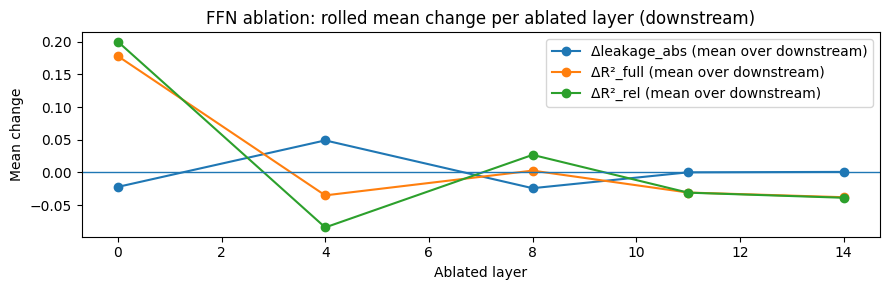

Eval layer 27 not present; available: [4, 8, 11, 15]
Top 12 heads by |dLeak_abs| across all ablations/eval layers:
  ablate L 0 → eval L 8 | H18 | Δleak=-0.769  ΔR²_full=+0.035  ΔR²_rel=+0.804  (base leak=0.778)
  ablate L 0 → eval L 4 | H19 | Δleak=-0.244  ΔR²_full=-0.023  ΔR²_rel=+0.221  (base leak=0.249)
  ablate L 4 → eval L11 | H14 | Δleak=+0.230  ΔR²_full=-0.049  ΔR²_rel=-0.279  (base leak=0.119)
  ablate L 4 → eval L11 | H10 | Δleak=+0.218  ΔR²_full=-0.069  ΔR²_rel=-0.287  (base leak=0.130)
  ablate L 4 → eval L15 | H20 | Δleak=+0.192  ΔR²_full=-0.036  ΔR²_rel=-0.227  (base leak=-0.001)
  ablate L 4 → eval L15 | H21 | Δleak=+0.180  ΔR²_full=-0.042  ΔR²_rel=-0.222  (base leak=-0.002)
  ablate L 4 → eval L 8 | H26 | Δleak=+0.172  ΔR²_full=-0.033  ΔR²_rel=-0.204  (base leak=0.005)
  ablate L 4 → eval L11 | H18 | Δleak=+0.166  ΔR²_full=-0.068  ΔR²_rel=-0.234  (base leak=0.076)
  ablate L 8 → eval L15 | H23 | Δleak=-0.159  ΔR²_full=-0.157  ΔR²_rel=+0.001  (base leak=-0.001)
  ablate 

In [30]:
# 1) rolled means per ablated layer
plot_layer_bar_ffn(ffn_summary)

# 2) heatmap at a specific eval layer (pick one shown in your textual summary, e.g., last layer)
plot_heatmap_delta_ffn(ffn_summary, eval_layer=27, vmax=0.25)  # set eval_layer as appropriate

# 3) top affected heads across all ablate->eval pairs
print_top_affected_ffn(ffn_summary, k=12)

In [31]:
def summarize_by_head_set(ffn_summary, head_ids_by_layer):
    # head_ids_by_layer: dict[layer] -> list of head ids to include
    out = {}
    for li, s in ffn_summary.items():
        pick = [r for r in s["stats"] if r["head"] in head_ids_by_layer.get(li, [])]
        if not pick: continue
        out[li] = {
            "n": len(pick),
            "mean_dLeak": float(np.nanmean([r["dLeak_abs"] for r in pick])),
            "mean_dR2_full": float(np.nanmean([r["dR2_full"] for r in pick])),
            "mean_dR2_rel":  float(np.nanmean([r["dR2_rel"]  for r in pick])),
        }
    return out


model device: cuda:0
input_ids device: cuda:0 dtype: torch.int64
attention_mask device: cuda:0 dtype: torch.int64


FFN scale sweep (layer 0):   0%|          | 0/6 [00:00<?, ?it/s]

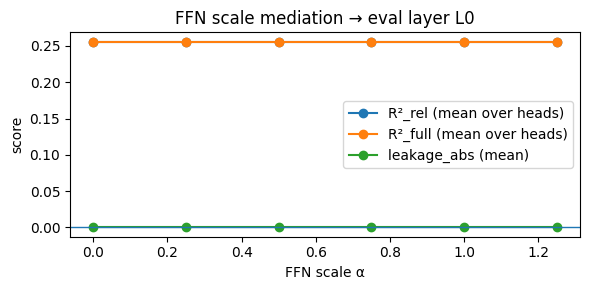

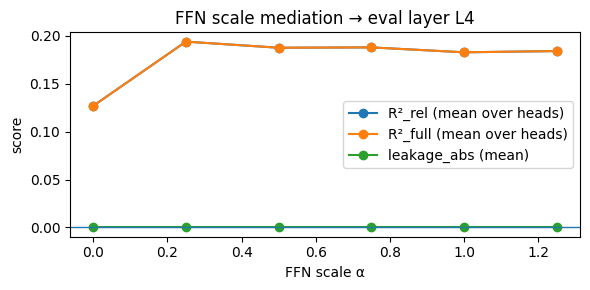

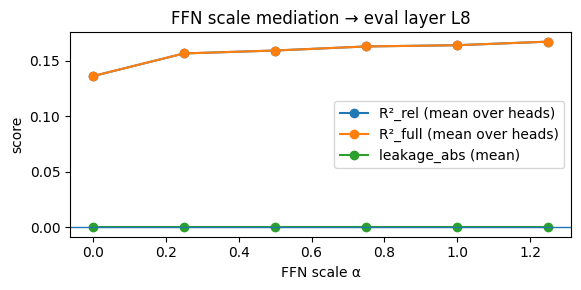

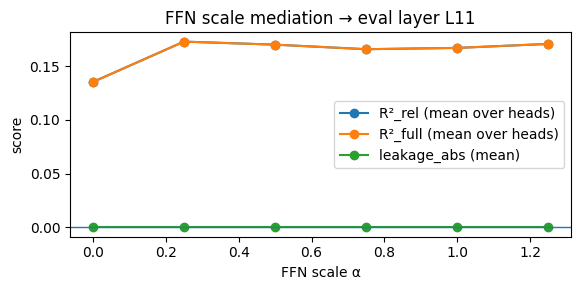

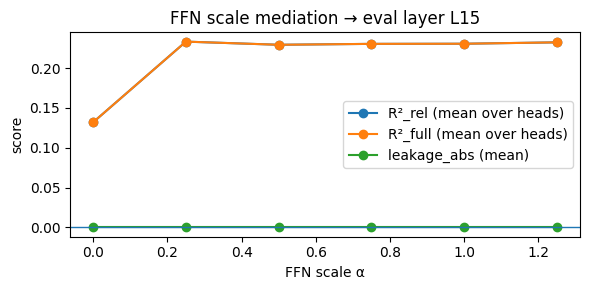

In [32]:
# === FFN SCALE SWEEP ===
import math, torch
from contextlib import contextmanager
from dataclasses import dataclass
from tqdm.auto import tqdm

FSS_SEQ_CAP     = 256
FSS_PAIRS       = 4000
FSS_ALPHAS      = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25]
FSS_HEADS_LIMIT = None
FSS_DTYPE_MATMUL = torch.bfloat16 # None for fp32

@dataclass
class LayerHeadData:
    Q: torch.Tensor
    K: torch.Tensor

def _get_block(layer_idx):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return model.model.layers[layer_idx]
    return model.layers[layer_idx]

def _get_mlp_mod(block):
    for name in ("mlp","feed_forward","ffn","ffn_layer","ff"):
        if hasattr(block, name): return getattr(block, name)
    raise RuntimeError("No MLP/FFN submodule found on block.")

@contextmanager
def ffn_scale_layer(layer_idx, alpha=1.0):
    """Scale MLP output by alpha (alpha=0: zero-out)."""
    block = _get_block(layer_idx)
    mlp = _get_mlp_mod(block)
    def _hook(mod, inputs, output):
        return output * float(alpha)
    h = mlp.register_forward_hook(_hook)
    try:
        yield
    finally:
        h.remove()

def _model_device():
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ensure a global `device` exists and matches model
if "device" not in globals():
    device = _model_device()
else:
    # if user defined 'device' but model sits elsewhere, follow the model
    try:
        _md = next(model.parameters()).device
        if _md != device:
            device = _md
    except StopIteration:
        pass


def _slice_enc_to_cap(cap):
    """
    Trim enc/current_prompt to `cap` tokens AND move to the model's device.
    """
    global enc
    if 'enc' in globals() and enc is not None:
        e = enc
    elif 'current_prompt_text' in globals() and 'tok' in globals():
        e = tok(current_prompt_text, return_tensors="pt")
    else:
        raise RuntimeError("No input found. Provide `enc` or define `current_prompt_text` + `tok`.")

    # slice first
    if 'input_ids' in e:         e['input_ids'] = e['input_ids'][:, :cap]
    if 'attention_mask' in e:    e['attention_mask'] = e['attention_mask'][:, :cap]

    # move in-place to model device (and correct dtypes)
    if 'input_ids' in e:
        e['input_ids'] = e['input_ids'].to(device, non_blocking=True)
        # make sure it's long for embeddings
        if e['input_ids'].dtype != torch.long:
            e['input_ids'] = e['input_ids'].long()
    if 'attention_mask' in e and e['attention_mask'] is not None:
        e['attention_mask'] = e['attention_mask'].to(device, non_blocking=True)

    enc = e  # persist back


def _get_current_encoding():
    """
    Always return tensors on the model's device.
    """
    if 'enc' not in globals() or enc is None:
        raise RuntimeError("`enc` not found; call _slice_enc_to_cap() first.")
    ids = enc['input_ids']
    am  = enc.get('attention_mask', None)
    # final safety: force to device here as well
    ids = ids.to(device, non_blocking=True)
    if ids.dtype != torch.long:
        ids = ids.long()
    if am is not None:
        am = am.to(device, non_blocking=True)
    return ids, am


def _run_with_capture():
    """
    Clear TRACE and run a forward pass using device-safe inputs.
    """
    if 'TRACE' not in globals():
        raise RuntimeError("TRACE dict not found. Make sure your capture hooks are installed.")
    # re-assert inputs are trimmed & on the correct device
    _slice_enc_to_cap(FSS_SEQ_CAP)
    input_ids, attn_mask = _get_current_encoding()
    TRACE.clear()
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attn_mask)  # never pass **enc


def _debug_print_devices():
    ids, am = _get_current_encoding()
    print("model device:", _model_device())
    print("input_ids device:", ids.device, "dtype:", ids.dtype)
    if am is not None:
        print("attention_mask device:", am.device, "dtype:", am.dtype)

_slice_enc_to_cap(FSS_SEQ_CAP); _debug_print_devices()

def _run_with_capture():
    if 'TRACE' not in globals():
        raise RuntimeError("TRACE not found; install your capture hooks first.")
    TRACE.clear()
    ids, am = _get_current_encoding()
    with torch.no_grad():
        _ = model(input_ids=ids, attention_mask=am)

def get_layer_head_mats(layer_idx: int):
    entries = TRACE.get(layer_idx, None)
    if not entries: return []
    last = entries[-1]
    q = last["q_rot"]  # [bs, n_q, seq, hd]
    k = last["k_rot"]  # [bs, n_kv, seq, hd]
    bs, n_q, seq, hd = q.shape
    _, n_kv, _, _ = k.shape
    if n_kv == n_q:
        k_exp = k
    else:
        k_exp = k.repeat_interleave(n_q // n_kv, dim=1)
    out=[]
    for h in range(n_q):
        Q = q[0,h,:seq,:].contiguous()
        K = k_exp[0,h,:seq,:].contiguous()
        out.append(LayerHeadData(Q=Q[:FSS_SEQ_CAP], K=K[:FSS_SEQ_CAP]))
    return out

def _sample_causal_pairs(seq, n_pairs, *, on_device):
    i = torch.randint(0, seq, (n_pairs,), device=on_device)
    j = (torch.rand((n_pairs,), device=on_device) * (i.to(torch.float32)+1)).floor().to(torch.long)
    d = (i - j).to(torch.long)
    return i, j, d

def _fast_leakage_from_logits(logits, i, j, d):
    y = logits[i,j].to(torch.float32)
    N = y.shape[0]; seq = logits.shape[0]
    X = torch.zeros((N, seq), device=y.device, dtype=torch.float32)
    X[torch.arange(N, device=y.device), d] = 1.0
    ones = torch.ones((N,1), device=y.device)

    X1 = torch.cat([ones, X], dim=1)
    try:    beta = torch.linalg.lstsq(X1, y).solution
    except: beta = torch.linalg.pinv(X1) @ y
    yhat = X1 @ beta
    ss_res = torch.sum((y - yhat)**2)
    ss_tot = torch.sum((y - torch.mean(y))**2) + 1e-12
    R2_full = 1.0 - (ss_res/ss_tot)

    try:    beta_rel = torch.linalg.lstsq(X, y).solution
    except: beta_rel = torch.linalg.pinv(X) @ y
    yhat_rel = X @ beta_rel
    ss_res_rel = torch.sum((y - yhat_rel)**2)
    R2_rel = 1.0 - (ss_res_rel/ss_tot)

    def _f(x):
        x=float(x);
        return max(min(x,1.0),-1.0) if math.isfinite(x) else float('nan')
    return _f(R2_rel), _f(R2_full), _f(R2_full - R2_rel)

def _compute_head_leakage_fast(Q, K, pairs=None):
    seq, hd = Q.shape
    scale = 1.0 / math.sqrt(hd)
    QQ, KK = Q, K
    if FSS_DTYPE_MATMUL is not None:
        QQ = QQ.to(FSS_DTYPE_MATMUL); KK = KK.to(FSS_DTYPE_MATMUL)
    logits = (QQ @ KK.T).to(torch.float32) * scale
    if pairs is None:
        pairs = _sample_causal_pairs(seq, FSS_PAIRS, on_device=logits.device)
    i,j,d = pairs
    if i.device != logits.device:
        i=i.to(logits.device); j=j.to(logits.device); d=d.to(logits.device)
    return _fast_leakage_from_logits(logits, i, j, d)

def run_ffn_scale_mediation(ablated_layer, eval_layers=None, alphas=FSS_ALPHAS):
    # set up input slice
    _slice_enc_to_cap(FSS_SEQ_CAP)

    # layer count + default evals
    if hasattr(model,"model") and hasattr(model.model,"layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)
    if eval_layers is None:
        first, last = 0, L-1
        mid = L//2
        q1  = (first+mid)//2
        q3  = (mid+last)//2
        eval_layers = sorted({first, q1, mid, q3, last})

    # baseline capture (alpha=1)
    _run_with_capture()
    # pre-sample pairs per eval layer on correct device
    pairs_by_layer = {}
    for li in eval_layers:
        ent = TRACE[li][-1]
        seq_len = min(ent["q_rot"].shape[2], FSS_SEQ_CAP)
        dev = ent["q_rot"].device
        pairs_by_layer[li] = _sample_causal_pairs(seq_len, FSS_PAIRS, on_device=dev)

    results = {li: {"alpha":[], "R2_rel_mean":[], "R2_full_mean":[], "leak_mean":[]} for li in eval_layers}

    for alpha in tqdm(alphas, desc=f"FFN scale sweep (layer {ablated_layer})"):
        with ffn_scale_layer(ablated_layer, alpha=alpha):
            _run_with_capture()
        for li in eval_layers:
            heads = get_layer_head_mats(li)
            if not heads:
                continue
            H = len(heads) if FSS_HEADS_LIMIT is None else min(FSS_HEADS_LIMIT,len(heads))
            R2r=[]; R2f=[]; Lk=[]
            for hi in range(H):
                Q,K = heads[hi].Q, heads[hi].K
                R2_rel, R2_full, leakage_abs = _compute_head_leakage_fast(Q, K, pairs=pairs_by_layer[li])
                R2r.append(R2_rel); R2f.append(R2_full); Lk.append(leakage_abs)
            results[li]["alpha"].append(alpha)
            results[li]["R2_rel_mean"].append(float(np.nanmean(R2r)))
            results[li]["R2_full_mean"].append(float(np.nanmean(R2f)))
            results[li]["leak_mean"].append(float(np.nanmean(Lk)))
    return results

import matplotlib.pyplot as plt
def plot_scale_mediation(results):
    for li, rec in sorted(results.items()):
        a = rec["alpha"]
        plt.figure(figsize=(6,3))
        plt.plot(a, rec["R2_rel_mean"],  marker='o', label="R²_rel (mean over heads)")
        plt.plot(a, rec["R2_full_mean"], marker='o', label="R²_full (mean over heads)")
        plt.plot(a, rec["leak_mean"],    marker='o', label="leakage_abs (mean)")
        plt.axhline(0, linewidth=1)
        plt.xlabel("FFN scale α")
        plt.ylabel("score")
        plt.title(f"FFN scale mediation → eval layer L{li}")
        plt.legend(); plt.tight_layout(); plt.show()

scale_curves = run_ffn_scale_mediation(ablated_layer=0)   # or 4, 8, 11, ...
plot_scale_mediation(scale_curves)


In [33]:
from sklearn.linear_model import LinearRegression

def probe_positional_info(hs, max_terms=8):
    """
    Probe how much positional info is present in hidden states.
    hs: [seq, d_model] FFN pre or post activations
    max_terms: number of Fourier/sinusoidal bases to include
    """
    seq = hs.shape[0]
    X = []
    pos = np.arange(seq)[:, None]

    # build sinusoidal design (instead of one-hot)
    for k in range(1, max_terms+1):
        X.append(np.sin(2*np.pi*k*pos/seq))
        X.append(np.cos(2*np.pi*k*pos/seq))
    X = np.hstack(X)

    # target: hidden states per dim
    Y = hs.cpu().numpy()

    lr = LinearRegression().fit(X, Y)
    R2 = lr.score(X, Y)
    return R2


In [34]:
for li, entries in TRACE_FFN.items():
    pre = entries[-1]["pre"]
    post = entries[-1]["post"]
    r2_pre = probe_positional_info(pre, max_terms=8)
    r2_post = probe_positional_info(post, max_terms=8)
    print(f"L{li}: R²(pre)={r2_pre:.3f}, R²(post)={r2_post:.3f}, Δ={r2_post-r2_pre:+.3f}")


L0: R²(pre)=0.108, R²(post)=0.099, Δ=-0.009
L1: R²(pre)=0.134, R²(post)=0.100, Δ=-0.034
L2: R²(pre)=0.156, R²(post)=0.130, Δ=-0.026
L3: R²(pre)=0.198, R²(post)=0.172, Δ=-0.026
L4: R²(pre)=0.226, R²(post)=0.207, Δ=-0.019
L5: R²(pre)=0.252, R²(post)=0.220, Δ=-0.032
L6: R²(pre)=0.279, R²(post)=0.247, Δ=-0.032
L7: R²(pre)=0.299, R²(post)=0.248, Δ=-0.051
L8: R²(pre)=0.288, R²(post)=0.221, Δ=-0.067
L9: R²(pre)=0.286, R²(post)=0.234, Δ=-0.051
L10: R²(pre)=0.263, R²(post)=0.212, Δ=-0.051
L11: R²(pre)=0.254, R²(post)=0.231, Δ=-0.024
L12: R²(pre)=0.259, R²(post)=0.212, Δ=-0.046
L13: R²(pre)=0.271, R²(post)=0.213, Δ=-0.058
L14: R²(pre)=0.270, R²(post)=0.210, Δ=-0.060
L15: R²(pre)=0.264, R²(post)=0.201, Δ=-0.063


In [35]:
# === Band-shift mediation: \Delta band shares after FFN intervention ===
import math, torch, numpy as np

try:
    ffn_scale_layer
except NameError:
    from contextlib import contextmanager
    def _get_block(layer_idx):
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            return model.model.layers[layer_idx]
        if hasattr(model, "layers"):
            return model.layers[layer_idx]
        raise RuntimeError("Could not locate transformer layers on `model`.")
    def _get_mlp_mod(block):
        if hasattr(block, "mlp"): return block.mlp
        for name in ("feed_forward","ffn","ffn_layer","ff"):
            if hasattr(block, name): return getattr(block, name)
        raise RuntimeError("Could not locate MLP/FFN submodule inside a block.")
    @contextmanager
    def ffn_scale_layer(layer_idx, alpha: float = 1.0):
        """
        Scale a layer's FFN output by `alpha` (alpha=1 → baseline, 0 → zeroed).
        """
        block = _get_block(layer_idx)
        mlp = _get_mlp_mod(block)
        def _scale_hook(mod, inputs, output):
            return output * float(alpha)
        h = mlp.register_forward_hook(_scale_hook)
        try:
            yield
        finally:
            h.remove()

# Helpers we rely on from the RoPE utilities:
# - rope_band_masks(head_dim, BAND_SLICES, model=model, ...)
# - pair_indices_to_dim_mask(pair_mask, head_dim=..., rotary_dim=...)
# - infer_rotary_dim(head_dim, model.config)

def _effective_rotary_dim(head_dim: int) -> int:
    cfg = getattr(model, "config", None)
    try:
        rd, _spec = infer_rotary_dim(head_dim, cfg)
    except Exception:
        rd = head_dim
    if rd % 2 == 1: rd -= 1
    rd = max(2, min(rd, head_dim))
    return rd

def _band_shares_for_layer(layer_idx):
    mats = get_layer_head_mats(layer_idx)
    if not mats:
        return []
    hd = mats[0].Q.shape[1]

    # RoPE bands over the rotated subspace only (handles partial RoPE)
    pair_masks = rope_band_masks(hd, BAND_SLICES, model=model)
    rotary_dim_eff = _effective_rotary_dim(hd)
    dim_masks  = {
        name: pair_indices_to_dim_mask(pm, head_dim=hd, rotary_dim=rotary_dim_eff)
        for name, pm in pair_masks.items()
    }

    out = []
    for hi, lh in enumerate(mats):
        Q = lh.Q.to(torch.float32)
        K = lh.K.to(torch.float32)
        full = (Q @ K.T)    # unscaled; we use Frobenius norms for shares
        total = torch.norm(full, p="fro").item() + 1e-12
        shares = {}
        for name, dm in dim_masks.items():
            if dm.numel() == 0 or dm.dtype != torch.bool or dm.sum().item() == 0:
                shares[name] = 0.0
                continue
            Qb = Q[:, dm]; Kb = K[:, dm]
            bl = Qb @ Kb.T
            shares[name] = float(torch.norm(bl, p="fro").item() / total)
        out.append({"head": hi, "shares": shares})
    return out

def band_shift_after_ffn(ablated_layer, eval_layers=None, alpha_before=1.0, alpha_after=0.0):
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        L = len(model.model.layers)
    else:
        L = len(model.layers)
    if eval_layers is None:
        first, last = 0, L-1
        mid = L // 2; q1 = (first + mid) // 2; q3 = (mid + last) // 2
        eval_layers = sorted({first, q1, mid, q3, last})

    # ensure enc is sliced like your other analyses
    seq_cap = globals().get("SEQ_CAP", 256)
    if 'enc' in globals() and enc is not None:
        for k in ('input_ids','attention_mask'):
            if k in enc: enc[k] = enc[k][:, :seq_cap]

    # baseline (alpha_before)
    with ffn_scale_layer(ablated_layer, alpha=alpha_before):
        _run_with_capture()
    base = {li: _band_shares_for_layer(li) for li in eval_layers}

    # intervention (alpha_after)
    with ffn_scale_layer(ablated_layer, alpha=alpha_after):
        _run_with_capture()
    post = {li: _band_shares_for_layer(li) for li in eval_layers}

    # Δ shares per head
    delta = {}
    for li in eval_layers:
        B = {x["head"]: x["shares"] for x in base.get(li, [])}
        P = {x["head"]: x["shares"] for x in post.get(li, [])}
        heads = sorted(set(B.keys()) & set(P.keys()))
        rows = []
        for h in heads:
            bands = sorted(B[h].keys())
            rows.append({
                "head": h,
                "dshares": {b: (P[h][b] - B[h][b]) for b in bands}
            })
        delta[li] = rows
    return base, post, delta

def print_band_shift(delta, topk=3):
    for li in sorted(delta.keys()):
        print(f"\n[Eval layer {li}]")
        for row in delta[li]:
            h = row["head"]
            items = sorted(row["dshares"].items(), key=lambda kv: abs(kv[1]), reverse=True)[:topk]
            txt = ", ".join([f"{b}:{v:+.3f}" for b, v in items])
            print(f"  head {h:2d}: {txt}")

base, post, delta = band_shift_after_ffn(ablated_layer=0, alpha_before=1.0, alpha_after=0.0)
print_band_shift(delta, topk=4)



[Eval layer 0]
  head  0: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  1: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  2: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  3: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  4: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  5: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  6: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  7: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  8: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head  9: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 10: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 11: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 12: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 13: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 14: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 15: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 16: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 17: b0:+0.000, b1:+0.000, b2:+0.000, b3:+0.000
  head 18: b

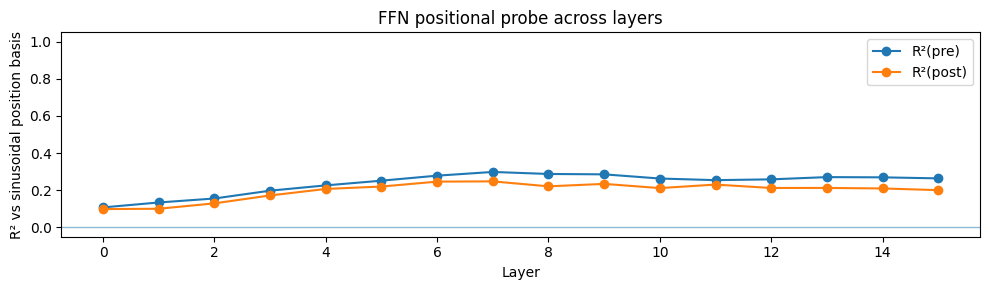

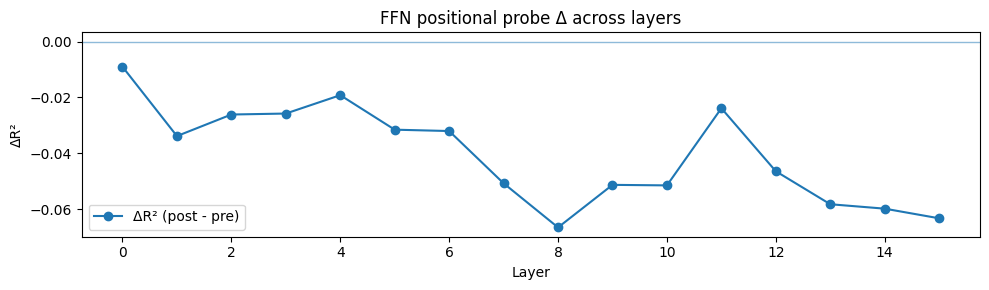

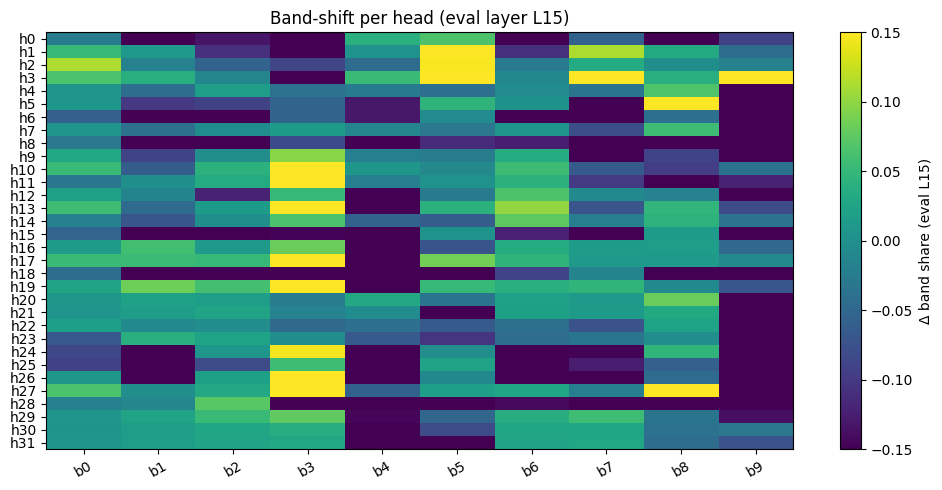

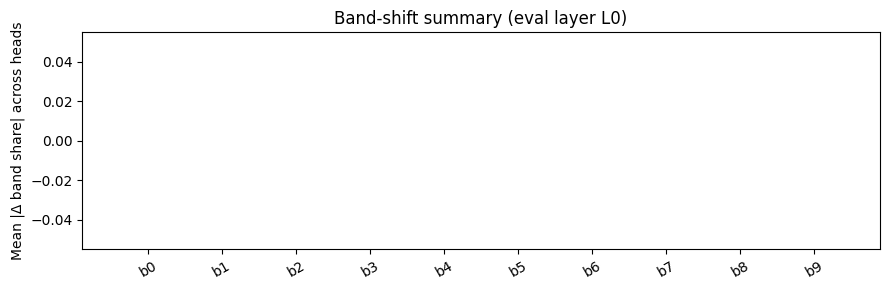

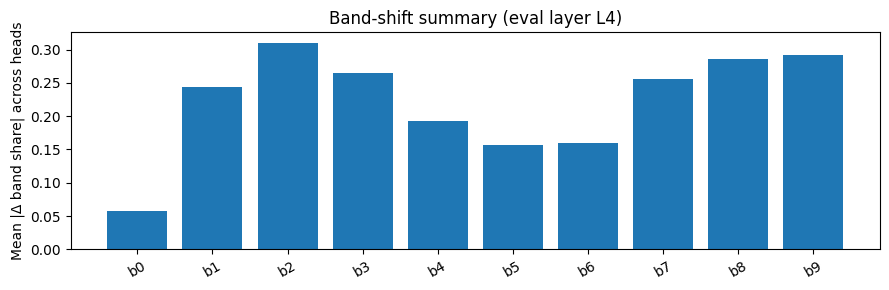

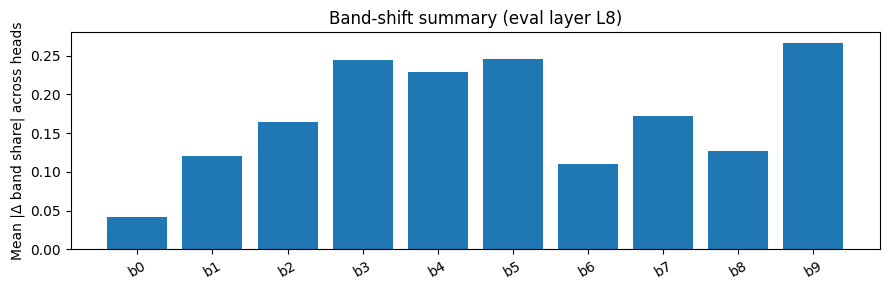

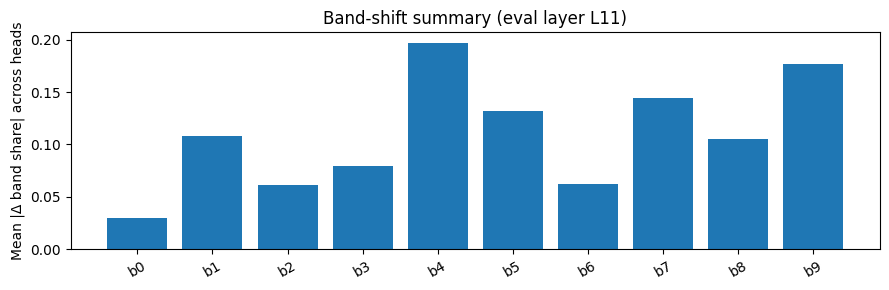

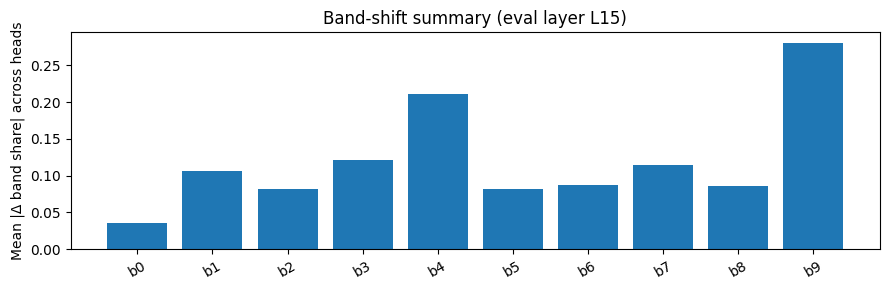

In [36]:
# === FFN positional probe across layers ===

def compute_ffn_positional_probe_across_layers(TRACE_FFN: dict, max_terms: int = 8):
    """
    Returns:
      probe = {
        layer_idx: {
          'R2_pre_mean': float, 'R2_pre_std': float,
          'R2_post_mean': float,'R2_post_std': float,
          'delta_mean': float,  'delta_std': float,
          'n_passes': int
        }, ...
      }
    Uses your `probe_positional_info(hs, max_terms)` for each captured pass and averages.
    """
    probe = {}
    for li, entries in sorted(TRACE_FFN.items()):
        if not entries:
            continue
        R2_pre, R2_post, dR = [], [], []
        for e in entries:
            pre = e.get("pre")
            post = e.get("post")
            if pre is None or post is None:
                continue
            r2_pre = float(probe_positional_info(pre, max_terms=max_terms))
            r2_post = float(probe_positional_info(post, max_terms=max_terms))
            R2_pre.append(r2_pre)
            R2_post.append(r2_post)
            dR.append(r2_post - r2_pre)
        if R2_pre:
            probe[li] = {
                "R2_pre_mean":  float(np.mean(R2_pre)),
                "R2_pre_std":   float(np.std(R2_pre)),
                "R2_post_mean": float(np.mean(R2_post)),
                "R2_post_std":  float(np.std(R2_post)),
                "delta_mean":   float(np.mean(dR)),
                "delta_std":    float(np.std(dR)),
                "n_passes":     int(len(R2_pre)),
            }
    return probe

def plot_ffn_positional_probe(probe_dict: dict):
    if not probe_dict:
        print("No FFN probe data. Did you run the FFN capture and build TRACE_FFN?")
        return
    layers = sorted(probe_dict.keys())
    pre  = [probe_dict[li]["R2_pre_mean"]  for li in layers]
    post = [probe_dict[li]["R2_post_mean"] for li in layers]
    dlt  = [probe_dict[li]["delta_mean"]   for li in layers]

    plt.figure(figsize=(10,3))
    plt.plot(layers, pre,  marker='o', label="R²(pre)")
    plt.plot(layers, post, marker='o', label="R²(post)")
    plt.axhline(0, linewidth=1, alpha=0.5)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Layer")
    plt.ylabel("R² vs sinusoidal position basis")
    plt.title("FFN positional probe across layers")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(layers, dlt, marker='o', label="ΔR² (post - pre)")
    plt.axhline(0, linewidth=1, alpha=0.5)
    plt.xlabel("Layer")
    plt.ylabel("ΔR²")
    plt.title("FFN positional probe Δ across layers")
    plt.legend()
    plt.tight_layout()
    plt.show()

ffn_probe = compute_ffn_positional_probe_across_layers(TRACE_FFN, max_terms=8)
plot_ffn_positional_probe(ffn_probe)


# Band-shift heatmaps (per eval layer, all heads)

def _band_names_from_delta(delta_for_layer: list) -> list[str]:
    """Infer a stable band order from the first row; fallback to sorted keys."""
    for row in delta_for_layer:
        if "dshares" in row and row["dshares"]:
            return sorted(row["dshares"].keys())
    # fallback
    keys = set()
    for row in delta_for_layer:
        keys.update(list(row.get("dshares", {}).keys()))
    return sorted(keys)

def plot_band_shift_heatmap(delta: dict, eval_layer: int | None = None, vmax: float | None = None):
    """
    Heatmap of Δ band share per HEAD for one evaluation layer.
    Rows = heads, Cols = bands. Values are Δshare (post - base).
    """
    if not delta:
        print("Empty delta dict. Run band_shift_after_ffn first.")
        return

    eval_layers = sorted(delta.keys())
    if eval_layer is None:
        eval_layer = eval_layers[-1]  # deepest by default
    if eval_layer not in delta:
        print(f"Eval layer {eval_layer} not present; available: {eval_layers}")
        return

    rows = delta[eval_layer]
    if not rows:
        print(f"No head entries for eval layer {eval_layer}.")
        return

    bands = _band_names_from_delta(rows)
    H = max([r.get("head", -1) for r in rows]) + 1
    M = np.full((H, len(bands)), np.nan, dtype=np.float32)

    for r in rows:
        h = int(r.get("head", -1))
        if h < 0 or h >= H:
            continue
        dsh = r.get("dshares", {})
        for b, name in enumerate(bands):
            M[h, b] = float(dsh.get(name, np.nan))

    plt.figure(figsize=(10, 5))
    plt.imshow(
        M, aspect="auto", interpolation="nearest",
        vmin=(-vmax if vmax is not None else None),
        vmax=(vmax if vmax is not None else None)
    )
    plt.colorbar(label=f"Δ band share (eval L{eval_layer})")
    plt.yticks(range(H), [f"h{h}" for h in range(H)])
    plt.xticks(range(len(bands)), bands, rotation=30)
    plt.title(f"Band-shift per head (eval layer L{eval_layer})")
    plt.tight_layout()
    plt.show()

def plot_band_shift_layer_summary(delta: dict):
    """
    For every evaluation layer in `delta`, plot bars of mean |Δshare| per band,
    averaged over heads.
    """
    if not delta:
        print("Empty delta dict.")
        return

    for li in sorted(delta.keys()):
        rows = delta[li]
        if not rows:
            continue
        bands = _band_names_from_delta(rows)
        vals = {b: [] for b in bands}
        for r in rows:
            for b in bands:
                v = float(r["dshares"].get(b, 0.0))
                vals[b].append(abs(v))
        means = [float(np.mean(vals[b])) if vals[b] else 0.0 for b in bands]

        plt.figure(figsize=(9,3))
        plt.bar(range(len(bands)), means)
        plt.xticks(range(len(bands)), bands, rotation=30)
        plt.ylabel("Mean |Δ band share| across heads")
        plt.title(f"Band-shift summary (eval layer L{li})")
        plt.tight_layout()
        plt.show()

base, post, delta = band_shift_after_ffn(ablated_layer=0, alpha_before=1.0, alpha_after=0.0)
plot_band_shift_heatmap(delta, eval_layer=None, vmax=0.15)   # auto-picks deepest if None
plot_band_shift_layer_summary(delta)
